In [79]:
pip install pmdarima

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
     ---------------------------------------- 0.0/572.7 kB ? eta -:--:--
     ------------------ ------------------- 276.5/572.7 kB 8.3 MB/s eta 0:00:01
     -------------------------------------- 572.7/572.7 kB 8.9 MB/s eta 0:00:00
     ---------------------------------------- 0.0/123.2 kB ? eta -:--:--
     ---------------------------------------- 123.2/123.2 kB ? eta 0:00:00
     ---------------------------------------- 0.0/298.0 kB ? eta -:--:--
     ------------------------------------- 298.0/298.0 kB 19.2 MB/s eta 0:00:00
     ---------------------------------------- 0.0/8.4 MB ? eta -:--:--
     - -------------------------------------- 0.2/8.4 MB ? eta -:--:--
     --- ------------------------------------ 0.8/8.4 MB 17.2 MB/s eta 0:00:01
     ---- ----------------------------------- 0.9/8.4 MB 9.7 MB/s eta 0:00:01
     ------ --------------------------------- 1.4/8.4 MB 8.8 MB/s eta 0:00:01
     -------- --


[notice] A new release of pip is available: 23.0.1 -> 23.1.2
[notice] To update, run: C:\Users\niekv\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [2]:
import os
import json
import sqlite3
import pandas as pd
from tqdm import tqdm
import csv
import plotly.express as px
# import matplotlib as plt
from matplotlib import pyplot as plt
import numpy as np
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

In [3]:
db = sqlite3.connect('crimes.db')
cur = db.cursor()

df_barnet = pd.read_sql("""SELECT *
                FROM crimes
                WHERE "LSOA_name" LIKE 'Barnet%' AND "Crime_type" LIKE 'Burglary'
                """, con=db)
df_barnet

Crime_ID    Month   
0                                                         2010-12  \
1                                                         2010-12   
2                                                         2010-12   
3                                                         2010-12   
4                                                         2010-12   
...                                                  ...      ...   
44187  fda0870be993d2c9352ae14a540bf529c15a7aa9d92a4e...  2023-03   
44188  c6c2d9a772695865f4ca33fce59c26c48fe3a1cdac8c22...  2023-03   
44189  e5bab2bd4f31de44515dbf125b85284392d0349139a1d3...  2023-03   
44190  823465427f8764e250a48312715a4bd87e8012412046c6...  2023-03   
44191  50b5bbf4987109ee189f8a736ec7e92365b25169b7f783...  2023-03   

                       Reported_by                 Falls_within  Longitude   
0      Metropolitan Police Service  Metropolitan Police Service  -0.201877  \
1      Metropolitan Police Service  Metropolitan Police Service  -0.207853   
2      Metropolitan Police Service  Metropolitan Police Service  -0.202510   
3      Metropolitan Police Service  Metropolitan Police Service  -0.206779   
4      Metropolitan Police Service  Metropolitan Police Service  -0.209537   
...                            ...                          ...        ...   
44187  Metropolitan Police Service  Metropolitan Police Service  -0.202163   
44188  Metropolitan Police Service  Metropolitan Police Service  -0.202163   
44189  Metropolitan Police Service  Metropolitan Police Service  -0.197843   
44190  Metropolitan Police Service  Metropolitan Police Service  -0.199449   
44191  Metropolitan Police Service  Metropolitan Police Service  -0.197843   

        Latitude                  Location  LSOA_code    LSOA_name Crime_type   
0      51.655538    On or near High Street  E01000248  Barnet 001A   Burglary  \
1      51.654317     On or near The Avenue  E01000248  Barnet 001A   Burglary   
2      51.656348     On or near Bruce Road  E01000248  Barnet 001A   Burglary   
3      51.654768      On or near The Drive  E01000248  Barnet 001A   Burglary   
4      51.655223  On or near Marriott Road  E01000249  Barnet 001B   Burglary   
...          ...                       ...        ...          ...        ...   
44187  51.559100   On or near Hocroft Road  E01000139  Barnet 041B   Burglary   
44188  51.559100   On or near Hocroft Road  E01000139  Barnet 041B   Burglary   
44189  51.561093    On or near Church Walk  E01000140  Barnet 041C   Burglary   
44190  51.563896  On or near Llanelly Road  E01000140  Barnet 041C   Burglary   
44191  51.561093    On or near Church Walk  E01000140  Barnet 041C   Burglary   

      Last_outcome_category Context  
0                                    
1                                    
2                                    
3                                    
4                                    
...                     ...     ...  
44187   Under investigation          
44188   Under investigation          
44189   Under investigation          
44190   Under investigation          
44191   Under investigation          

[44192 rows x 12 columns]

In [4]:
wards = pd.read_csv('C:/Users/niekv/Downloads/LSOA_(2021)_to_Ward_to_Lower_Tier_Local_Authority_(May_2022)_Lookup_for_England_and_Wales.csv')
wards = wards[wards['LSOA21NM'].str.contains('Barnet')]
wards_sorted = wards.groupby('WD22NM')['LSOA21NM'].apply(list).reset_index(name='LSAO name')
wards_list = wards_sorted.values.tolist()

df_barnet['Wards'] = 1
df_barnet['Wards num'] = 1
for i in range(len(df_barnet)):
    if df_barnet['LSOA_name'][i] in wards_list[0][1]:
        df_barnet['Wards'][i] = 'Barnet Vale'
        df_barnet['Wards num'][i] = '1'
    elif df_barnet['LSOA_name'][i] in wards_list[1][1]:
        df_barnet['Wards'][i] = wards_list[1][0]
        df_barnet['Wards num'][i] = '2'
    elif df_barnet['LSOA_name'][i] in wards_list[2][1]:
        df_barnet['Wards'][i] = wards_list[2][0]
        df_barnet['Wards num'][i] = '3'
    elif df_barnet['LSOA_name'][i] in wards_list[3][1]:
        df_barnet['Wards'][i] = wards_list[3][0]
        df_barnet['Wards num'][i] = '3'
    elif df_barnet['LSOA_name'][i] in wards_list[4][1]:
        df_barnet['Wards'][i] = wards_list[4][0]
        df_barnet['Wards num'][i] = '4'
    elif df_barnet['LSOA_name'][i] in wards_list[5][1]:
        df_barnet['Wards'][i] = wards_list[5][0]
        df_barnet['Wards num'][i] = '5'
    elif df_barnet['LSOA_name'][i] in wards_list[6][1]:
        df_barnet['Wards'][i] = wards_list[6][0]
        df_barnet['Wards num'][i] = '6'
    elif df_barnet['LSOA_name'][i] in wards_list[7][1]:
        df_barnet['Wards'][i] = wards_list[7][0]
        df_barnet['Wards num'][i] = '7'
    elif df_barnet['LSOA_name'][i] in wards_list[8][1]:
        df_barnet['Wards'][i] = wards_list[8][0]
        df_barnet['Wards num'][i] = '8'
    elif df_barnet['LSOA_name'][i] in wards_list[9][1]:
        df_barnet['Wards'][i] = wards_list[9][0]
        df_barnet['Wards num'][i] = '9'
    elif df_barnet['LSOA_name'][i] in wards_list[10][1]:
        df_barnet['Wards'][i] = wards_list[10][0]
        df_barnet['Wards num'][i] = '10'
    elif df_barnet['LSOA_name'][i] in wards_list[11][1]:
        df_barnet['Wards'][i] = wards_list[11][0]
        df_barnet['Wards num'][i] = '11'
    elif df_barnet['LSOA_name'][i] in wards_list[12][1]:
        df_barnet['Wards'][i] = wards_list[12][0]
        df_barnet['Wards num'][i] = '12'
    elif df_barnet['LSOA_name'][i] in wards_list[13][1]:
        df_barnet['Wards'][i] = wards_list[13][0]
        df_barnet['Wards num'][i] = '13'
    elif df_barnet['LSOA_name'][i] in wards_list[14][1]:
        df_barnet['Wards'][i] = wards_list[14][0]
        df_barnet['Wards num'][i] = '14'
    elif df_barnet['LSOA_name'][i] in wards_list[15][1]:
        df_barnet['Wards'][i] = wards_list[15][0]
        df_barnet['Wards num'][i] = '15'
    elif df_barnet['LSOA_name'][i] in wards_list[16][1]:
        df_barnet['Wards'][i] = wards_list[16][0]
        df_barnet['Wards num'][i] = '16'
    elif df_barnet['LSOA_name'][i] in wards_list[17][1]:
        df_barnet['Wards'][i] = wards_list[17][0]
        df_barnet['Wards num'][i] = '17'
    elif df_barnet['LSOA_name'][i] in wards_list[18][1]:
        df_barnet['Wards'][i] = wards_list[18][0]
        df_barnet['Wards num'][i] = '18'
    elif df_barnet['LSOA_name'][i] in wards_list[19][1]:
        df_barnet['Wards'][i] = wards_list[19][0]
        df_barnet['Wards num'][i] = '19'
    elif df_barnet['LSOA_name'][i] in wards_list[20][1]:
        df_barnet['Wards'][i] = wards_list[20][0]
        df_barnet['Wards num'][i] = '20'
    elif df_barnet['LSOA_name'][i] in wards_list[21][1]:
        df_barnet['Wards'][i] = wards_list[21][0]
        df_barnet['Wards num'][i] = '21'
    elif df_barnet['LSOA_name'][i] in wards_list[22][1]:
        df_barnet['Wards'][i] = wards_list[22][0]
        df_barnet['Wards num'][i] = '22'
    elif df_barnet['LSOA_name'][i] in wards_list[23][1]:
        df_barnet['Wards'][i] = wards_list[23][0]
        df_barnet['Wards num'][i] = '23'
    else:
        df_barnet.drop(i)

wards_l = ['Barnet Vale',
'Brunswick Park',
'Burnt Oak',
'Childs Hill',
'Colindale North',
'Colindale South',
'Cricklewood',
'East Barnet',
'East Finchley',
'Edgware',
'Edgwarebury',
'Finchley Church End',
'Friern Barnet',
'Garden Suburb',
'Golders Green',
'Hendon',
'High Barnet',
'Mill Hill',
'Totteridge & Woodside',
'Underhill',
'West Finchley',
'West Hendon',
'Whetstone',
'Woodhouse']

df_barnet_filtered = df_barnet[df_barnet['Wards'].isin(wards_l)]
df_barnet_filtered

C:\Users\niekv\AppData\Local\Temp\ipykernel_16704\3621821869.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_barnet['Wards'][i] = wards_list[16][0]
C:\Users\niekv\AppData\Local\Temp\ipykernel_16704\3621821869.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_barnet['Wards num'][i] = '16'


Crime_ID    Month   
0                                                         2010-12  \
1                                                         2010-12   
2                                                         2010-12   
3                                                         2010-12   
4                                                         2010-12   
...                                                  ...      ...   
44187  fda0870be993d2c9352ae14a540bf529c15a7aa9d92a4e...  2023-03   
44188  c6c2d9a772695865f4ca33fce59c26c48fe3a1cdac8c22...  2023-03   
44189  e5bab2bd4f31de44515dbf125b85284392d0349139a1d3...  2023-03   
44190  823465427f8764e250a48312715a4bd87e8012412046c6...  2023-03   
44191  50b5bbf4987109ee189f8a736ec7e92365b25169b7f783...  2023-03   

                       Reported_by                 Falls_within  Longitude   
0      Metropolitan Police Service  Metropolitan Police Service  -0.201877  \
1      Metropolitan Police Service  Metropolitan Police Service  -0.207853   
2      Metropolitan Police Service  Metropolitan Police Service  -0.202510   
3      Metropolitan Police Service  Metropolitan Police Service  -0.206779   
4      Metropolitan Police Service  Metropolitan Police Service  -0.209537   
...                            ...                          ...        ...   
44187  Metropolitan Police Service  Metropolitan Police Service  -0.202163   
44188  Metropolitan Police Service  Metropolitan Police Service  -0.202163   
44189  Metropolitan Police Service  Metropolitan Police Service  -0.197843   
44190  Metropolitan Police Service  Metropolitan Police Service  -0.199449   
44191  Metropolitan Police Service  Metropolitan Police Service  -0.197843   

        Latitude                  Location  LSOA_code    LSOA_name Crime_type   
0      51.655538    On or near High Street  E01000248  Barnet 001A   Burglary  \
1      51.654317     On or near The Avenue  E01000248  Barnet 001A   Burglary   
2      51.656348     On or near Bruce Road  E01000248  Barnet 001A   Burglary   
3      51.654768      On or near The Drive  E01000248  Barnet 001A   Burglary   
4      51.655223  On or near Marriott Road  E01000249  Barnet 001B   Burglary   
...          ...                       ...        ...          ...        ...   
44187  51.559100   On or near Hocroft Road  E01000139  Barnet 041B   Burglary   
44188  51.559100   On or near Hocroft Road  E01000139  Barnet 041B   Burglary   
44189  51.561093    On or near Church Walk  E01000140  Barnet 041C   Burglary   
44190  51.563896  On or near Llanelly Road  E01000140  Barnet 041C   Burglary   
44191  51.561093    On or near Church Walk  E01000140  Barnet 041C   Burglary   

      Last_outcome_category Context        Wards Wards num  
0                                    High Barnet        16  
1                                    High Barnet        16  
2                                    High Barnet        16  
3                                    High Barnet        16  
4                                    High Barnet        16  
...                     ...     ...          ...       ...  
44187   Under investigation          Childs Hill         3  
44188   Under investigation          Childs Hill         3  
44189   Under investigation          Childs Hill         3  
44190   Under investigation          Childs Hill         3  
44191   Under investigation          Childs Hill         3  

[42562 rows x 14 columns]

In [5]:
df_barnet_filtered['Wards'].unique()

array(['High Barnet', 'Underhill', 'East Barnet', 'Barnet Vale',
       'Edgwarebury', 'Totteridge & Woodside', 'Whetstone',
       'Brunswick Park', 'Woodhouse', 'Edgware', 'Friern Barnet',
       'Mill Hill', 'Burnt Oak', 'West Finchley', 'Finchley Church End',
       'Colindale North', 'East Finchley', 'Hendon', 'Garden Suburb',
       'West Hendon', 'Golders Green', 'Childs Hill', 'Cricklewood'],
      dtype=object)

In [6]:
df_high_barnet = df_barnet_filtered[df_barnet_filtered['Wards'] == 'High Barnet']
df_underhill = df_barnet_filtered[df_barnet_filtered['Wards'] == 'Underhill']
df_east_barnet = df_barnet_filtered[df_barnet_filtered['Wards'] == 'East Barnet']
df_barnet_vale = df_barnet_filtered[df_barnet_filtered['Wards'] == 'Barnet Vale']
df_edgwarebury = df_barnet_filtered[df_barnet_filtered['Wards'] == 'Edgwarebury']
df_totteridge_and_woodside = df_barnet_filtered[df_barnet_filtered['Wards'] == 'Totteridge & Woodside']
df_whetstone = df_barnet_filtered[df_barnet_filtered['Wards'] == 'Whetstone']
df_brunswick_park = df_barnet_filtered[df_barnet_filtered['Wards'] == 'Brunswick Park']
df_woodhouse = df_barnet_filtered[df_barnet_filtered['Wards'] == 'Woodhouse']
df_edgware = df_barnet_filtered[df_barnet_filtered['Wards'] == 'Edgware']
df_friern_barnet = df_barnet_filtered[df_barnet_filtered['Wards'] == 'Friern Barnet']
df_mill_hill = df_barnet_filtered[df_barnet_filtered['Wards'] == 'Mill Hill']
df_burnt_oak = df_barnet_filtered[df_barnet_filtered['Wards'] == 'Burnt Oak']
df_west_finchley = df_barnet_filtered[df_barnet_filtered['Wards'] == 'West Finchley']
df_finchley_church_end = df_barnet_filtered[df_barnet_filtered['Wards'] == 'Finchley Church End']
df_colindale_north = df_barnet_filtered[df_barnet_filtered['Wards'] == 'Colindale North']
df_east_finchley = df_barnet_filtered[df_barnet_filtered['Wards'] == 'East Finchley']
df_hendon = df_barnet_filtered[df_barnet_filtered['Wards'] == 'Hendon']
df_garden_suburb = df_barnet_filtered[df_barnet_filtered['Wards'] == 'Garden Suburb']
df_west_hendon = df_barnet_filtered[df_barnet_filtered['Wards'] == 'West Hendon']
df_golders_green = df_barnet_filtered[df_barnet_filtered['Wards'] == 'Golders Green']
df_childs_hill = df_barnet_filtered[df_barnet_filtered['Wards'] == 'Childs Hill']
df_cricklewood = df_barnet_filtered[df_barnet_filtered['Wards'] == 'Cricklewood']

df_wards = [df_high_barnet, df_underhill, df_east_barnet, df_barnet_vale, df_edgwarebury, df_totteridge_and_woodside, df_whetstone, df_brunswick_park, df_woodhouse, df_edgware, df_friern_barnet, 
            df_mill_hill, df_burnt_oak, df_west_finchley, df_finchley_church_end, df_colindale_north, df_east_finchley, df_hendon, df_garden_suburb, df_west_hendon, df_golders_green,
            df_childs_hill, df_cricklewood]
df_wards


[                                                Crime_ID    Month   
 0                                                         2010-12  \
 1                                                         2010-12   
 2                                                         2010-12   
 3                                                         2010-12   
 4                                                         2010-12   
 ...                                                  ...      ...   
 43962  1b0f5b54b22756b1f34b5bec61722c2c908d8d0a9a2f69...  2023-03   
 43963  e52bf021cbf673d1a3742f2ffc7033f164958ebdf5ad25...  2023-03   
 43964  7a76fc7afe13407ff094607b6a800d8c74a7034435a950...  2023-03   
 43965  5b6d78a73254fdd37f71f290fc62e262e1bd5194c28435...  2023-03   
 43986  633fb9897f36482cc575c45d17f0761a7457add59f58da...  2023-03   
 
                        Reported_by                 Falls_within  Longitude   
 0      Metropolitan Police Service  Metropolitan Police Service  -0.201877  \


In [7]:
df_high_barnet_grouped = df_high_barnet.groupby('Month')
df_high_barnet_count = df_high_barnet_grouped.count()
df_high_barnet_count['Crime_ID'] = df_high_barnet_count['Crime_ID'].astype(int)
df_high_barnet_count = df_high_barnet_count[['Crime_ID']]
df = df_high_barnet_count.rename(columns={'Crime_ID': 'value'})
df

value
Month         
2010-12     14
2011-01     21
2011-02     15
2011-03     17
2011-04     18
...        ...
2022-10      7
2022-11     10
2023-01      9
2023-02      7
2023-03      7

[147 rows x 1 columns]

In [8]:
from statsmodels.tsa.stattools import adfuller
from numpy import log
import numpy as np, pandas as pd
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt
from pmdarima.arima.utils import ndiffs
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_predict
from statsmodels.tsa.arima.model import ARIMAResults
from statsmodels.tsa.stattools import acf
import pmdarima as pm
from sklearn.metrics import mean_squared_error
from pmdarima.metrics import smape

In [65]:
# Find order of differencing
result = adfuller(df.value.dropna())
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: -5.196414
p-value: 0.000009


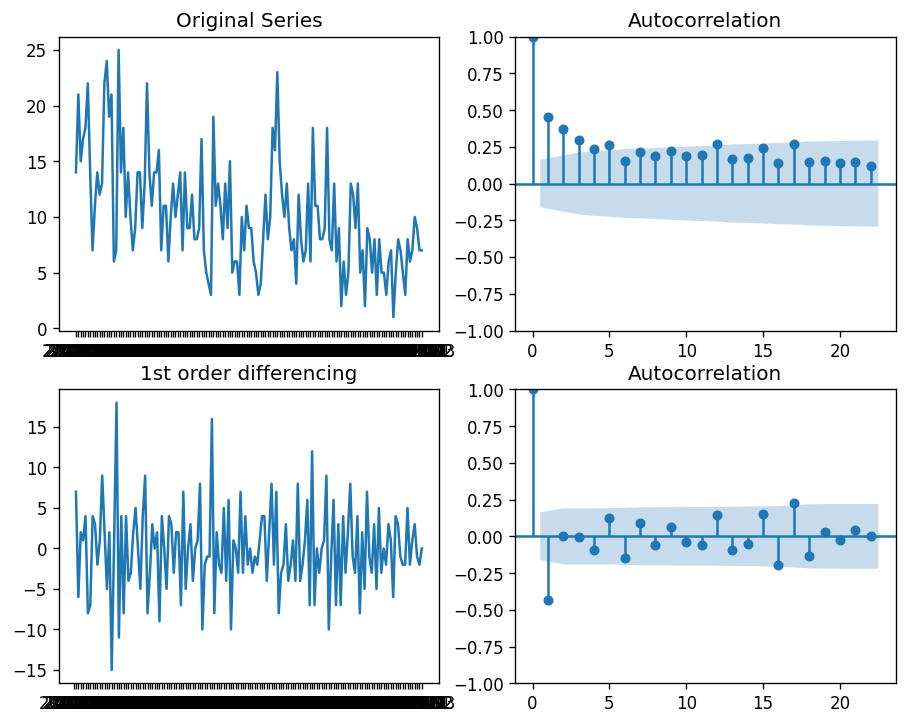

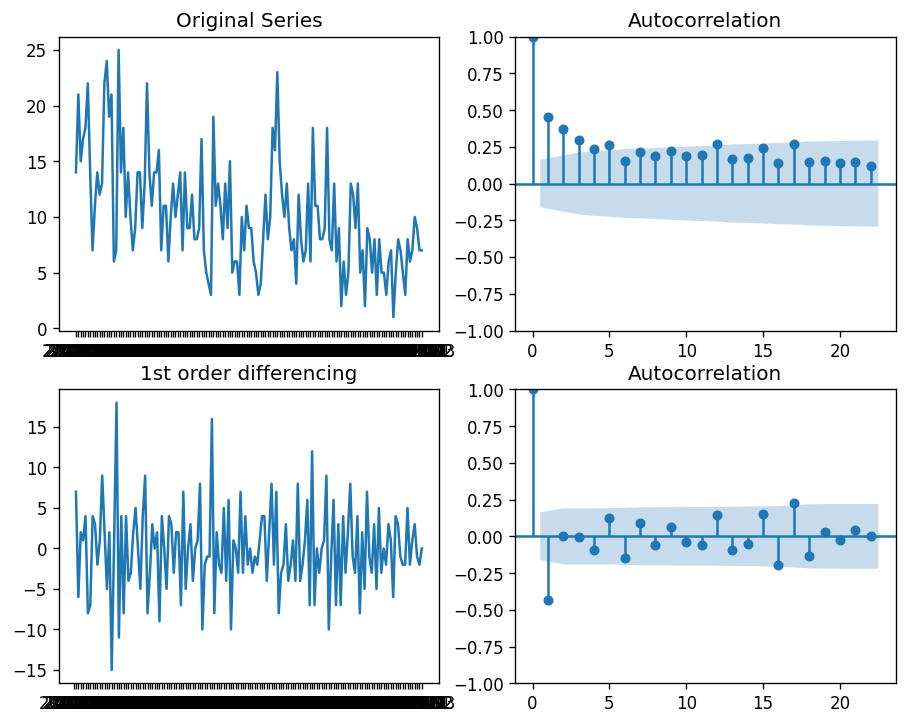

In [77]:
# Find order of differencing
plt.rcParams.update({'figure.figsize':(9,7), 'figure.dpi':120})

# Original series
fig, axes = plt.subplots(2, 2, sharex=False)
axes[0,0].plot(df.value); axes[0,0].set_title('Original Series')
plot_acf(df.value, ax=axes[0,1])

# 1st differencing 
axes[1,0].plot(df.value.diff()); axes[1,0].set_title('1st order differencing')
plot_acf(df.value.diff().dropna(), ax=axes[1,1])

In [82]:
# Find order of differencing
y = df.value

## Adf Test, KPSS test, PP test
ndiffs(y, test='adf'), ndiffs(y, test='kpss'), ndiffs(y, test='pp')

(0, 1, 0)

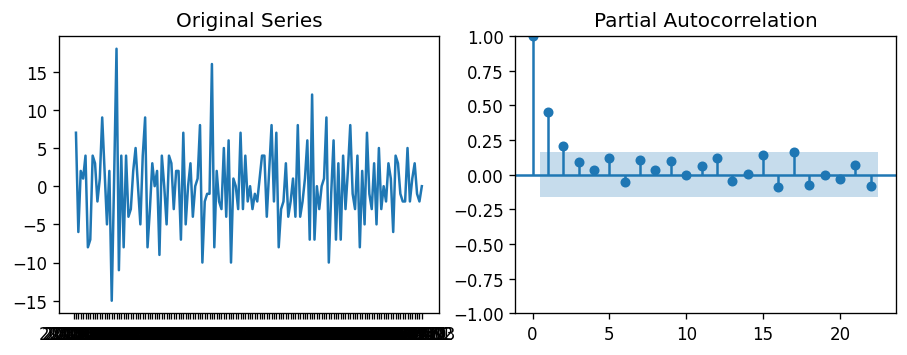

In [86]:
# Find the order of the AR term (p)
plt.rcParams.update({'figure.figsize':(9,3), 'figure.dpi':120})

fig, axes = plt.subplots(1, 2, sharex=False)
axes[0].plot(df.value.diff()); axes[0].set_title('Original Series')
axes[1].set(ylim=(0,5))
plot_pacf(df.value.dropna(), ax=axes[1])

plt.show()

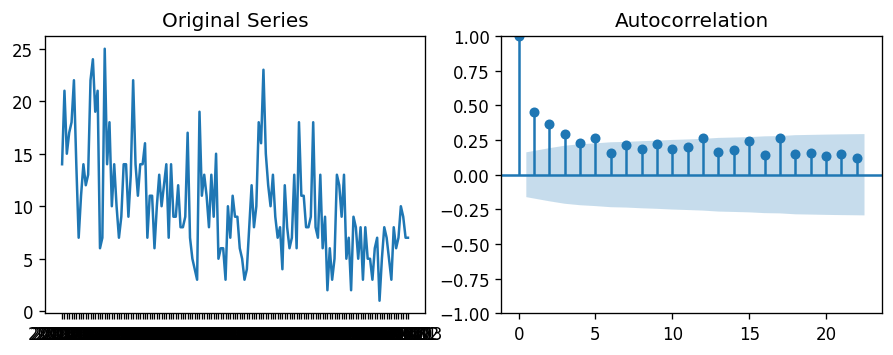

In [92]:
# Find the order of the MA term (q)
plt.rcParams.update({'figure.figsize':(9,3), 'figure.dpi':120})

fig, axes = plt.subplots(1, 2, sharex=False)
axes[0].plot(df.value); axes[0].set_title('Original Series')
axes[1].set(ylim=(0,1.2))
plot_acf(df.value.dropna(), ax=axes[1])

plt.show()

C:\Users\niekv\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\niekv\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\niekv\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. fore

                               SARIMAX Results                                
Dep. Variable:                  value   No. Observations:                  147
Model:                 ARIMA(4, 3, 4)   Log Likelihood                -429.024
Date:                Sun, 21 May 2023   AIC                            876.049
Time:                        18:31:28   BIC                            902.777
Sample:                             0   HQIC                           886.910
                                - 147                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -2.0361      0.110    -18.512      0.000      -2.252      -1.820
ar.L2         -1.9616      0.215     -9.119      0.000      -2.383      -1.540
ar.L3         -0.8642      0.194     -4.450      0.0

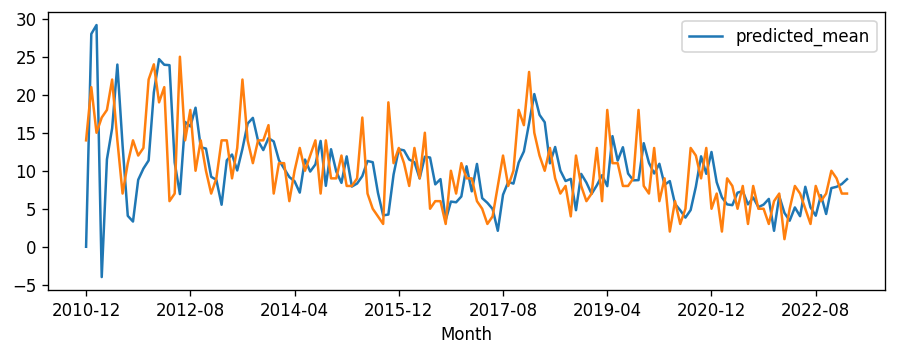

In [355]:
p = 4
d = 3
q = 4
p, d, q
model = ARIMA(df.value, order=(p, d, q))
model_fit = model.fit()
print(model_fit.summary())
# Plot to see resiual errors
residuals = pd.DataFrame(model_fit.resid)
# fig, ax = plt.subplots(1,2)
# residuals.plot(title="Residuals", ax=ax[0])
# residuals.plot(kind='kde', title='Density', ax=ax[1])
# plt.show()

# Plot the actual vs fitted
predictions = ARIMAResults.predict(model_fit, dynamic=False)
df_predictions = predictions.to_frame()
df_predictions.plot.line()
plt.plot(df.value)


C:\Users\niekv\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\niekv\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\niekv\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\niekv\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\l

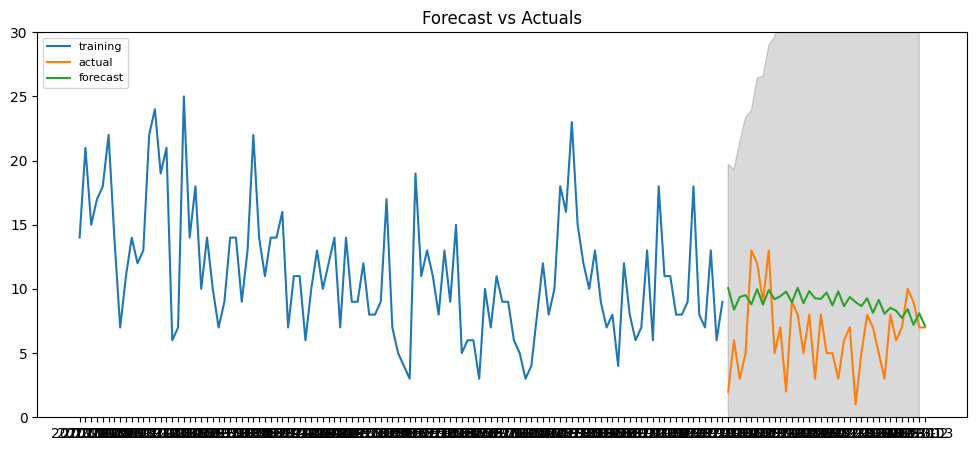

In [344]:
# Create Training and Test
train = df.value[:112]
test = df.value[112:]

# Build model
model = ARIMA(train, order=(4,3,4))
fitted = model.fit()
# print(fitted.summary())

# Forecast
forecast = fitted.get_forecast(35, alpha=0.05)
fc = forecast._predicted_mean
se = forecast.se_mean
conf = forecast.conf_int(fc)

# Make as pandas series
fc_series = pd.Series(fc, index=test.index)
lower_series = pd.Series(conf[:]['lower value'], index=test.index)
upper_series = pd.Series(conf[:]['upper value'], index=test.index)

# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.ylim([0,30])
plt.show()
# print(conf.loc[:])

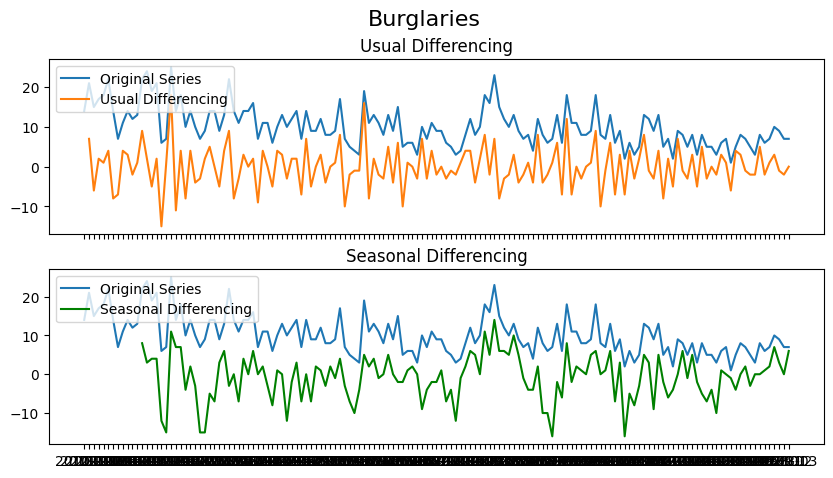

In [9]:
# Plot
fig, axes = plt.subplots(2, 1, figsize=(10,5), dpi=100, sharex=True)

# Usual Differencing
axes[0].plot(df.value[:], label='Original Series')
axes[0].plot(df.value[:].diff(1), label='Usual Differencing')
axes[0].set_title('Usual Differencing')
axes[0].legend(loc='upper left', fontsize=10)


# Seasinal Dei
axes[1].plot(df.value[:], label='Original Series')
axes[1].plot(df.value[:].diff(12), label='Seasonal Differencing', color='green')
axes[1].set_title('Seasonal Differencing')
plt.legend(loc='upper left', fontsize=10)
plt.suptitle('Burglaries', fontsize=16)
plt.show()

In [20]:
# Function to forecast data
def predictions_func(df, train_size, name):

    df_grouped = df.groupby('Month')
    df_count = df_grouped.count()
    df_count['Crime_ID'] = df_count['Crime_ID'].astype(int)
    df__count = df_count[['Crime_ID']]
    df = df_count.rename(columns={'Crime_ID': 'value'})
    df

    # Seasonal ARIMA model
    # Create Training and Test
    train = df.value[:train_size]
    test = df.value[train_size:]


    smodel = pm.auto_arima(train, start_p=1, start_q=1, test='adf',
                        max_p=5, max_q=5, m=12,
                        seasonal=True, d=None, D=1, trace=True,
                        error_action='ignore', suppress_warnings=True,
                        stepwise=True)
    summary = smodel.summary()


    model = smodel  # seeded from the model we've already fit

    def forecast_one_step():
        fc, conf_int = model.predict(n_periods=1, return_conf_int=True, alpha=0.05)
        return (
            fc.tolist()[0],
            np.asarray(conf_int).tolist()[0])

    forecasts = []
    confidence_intervals = []

    for new_ob in test:
        fc, conf = forecast_one_step()
        forecasts.append(fc)
        confidence_intervals.append(conf)

        # Updates the existing model with a small number of MLE steps
        model.update(new_ob)

    print(f"Mean squared error: {mean_squared_error(test, forecasts)}")
    print(f"SMAPE: {smape(test, forecasts)}")
    fig, axes = plt.subplots(2, 1, figsize=(12, 12))

    # --------------------- Actual vs. Predicted --------------------------
    axes[0].plot(train, color='blue', label='Training Data')
    axes[0].plot(test.index, forecasts, color='green', marker='o',
                label='Predicted Burglaries')

    axes[0].plot(test.index, test, color='red', label='Burglaries')
    axes[0].set_title(f'Number of Burglaries Prediction {name}')
    axes[0].set_xlabel('Dates')
    axes[0].set_ylabel('Burglaries')

    axes[0].set_xticks(np.arange(0, 147, 18).tolist(), df.index[0:147:18].tolist())
    axes[0].legend()


    # ------------------ Predicted with confidence intervals ----------------
    axes[1].plot(train, color='blue', label='Training Data')
    axes[1].plot(test.index, forecasts, color='green',
                label='Predicted Burglaries')

    axes[1].set_title(f'Burglary Predictions & Confidence Intervals {name}')
    axes[1].set_xlabel('Dates')
    axes[1].set_ylabel('Burglaries')

    conf_int = np.asarray(confidence_intervals)
    axes[1].fill_between(test.index,
                        conf_int[:, 0], conf_int[:, 1],
                        alpha=0.9, color='orange',
                        label="Confidence Intervals")

    axes[1].set_xticks(np.arange(0, 147, 18).tolist(), df.index[0:147:18].tolist())
    axes[1].legend()
    return smodel, summary, fig

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(1,1,1)[12] intercept   : AIC=inf, Time=0.65 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=705.040, Time=0.01 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=679.229, Time=0.11 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=0.28 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=704.565, Time=0.02 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=697.092, Time=0.03 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=670.218, Time=0.38 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=0.98 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=0.42 sec
 ARIMA(0,0,0)(2,1,0)[12] intercept   : AIC=678.819, Time=0.29 sec
 ARIMA(2,0,0)(2,1,0)[12] intercept   : AIC=670.794, Time=0.41 sec
 ARIMA(1,0,1)(2,1,0)[12] intercept   : AIC=671.280, Time=0.40 sec
 ARIMA(0,0,1)(2,1,0)[12] intercept   : AIC=672.688, Time=0.47 sec
 ARIMA(2,0,1)(2,1,0)[12] intercept   : AIC=inf, Time=1.04 sec
 ARIMA(1,0,0)(2,1,0)[12]             : AIC=671.278, T

C:\Users\niekv\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\niekv\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


Mean squared error: 12.520605117647607
SMAPE: 49.116003792714764
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(1,1,1)[12] intercept   : AIC=652.126, Time=0.45 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=676.129, Time=0.02 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=657.782, Time=0.12 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=655.275, Time=0.11 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=675.486, Time=0.02 sec
 ARIMA(1,0,1)(0,1,1)[12] intercept   : AIC=650.260, Time=0.26 sec
 ARIMA(1,0,1)(0,1,0)[12] intercept   : AIC=676.612, Time=0.10 sec
 ARIMA(1,0,1)(0,1,2)[12] intercept   : AIC=652.207, Time=0.75 sec
 ARIMA(1,0,1)(1,1,0)[12] intercept   : AIC=651.967, Time=0.18 sec
 ARIMA(1,0,1)(1,1,2)[12] intercept   : AIC=653.213, Time=0.74 sec
 ARIMA(1,0,0)(0,1,1)[12] intercept   : AIC=653.866, Time=0.09 sec
 ARIMA(2,0,1)(0,1,1)[12] intercept   : AIC=652.222, Time=0.35 sec
 ARIMA(1,0,2)(0,1,1)[12] intercept   : AIC=652.220, Time=0.36 sec
 ARIMA(0,0,0)(0,1,1)[12] intercept

C:\Users\niekv\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\niekv\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


Mean squared error: 9.344701786184801
SMAPE: 48.45833124186365
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(1,1,1)[12] intercept   : AIC=inf, Time=0.57 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=733.204, Time=0.02 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=695.353, Time=0.14 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=0.25 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=731.846, Time=0.02 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=735.156, Time=0.04 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=691.653, Time=0.36 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=0.95 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=0.42 sec
 ARIMA(0,0,0)(2,1,0)[12] intercept   : AIC=690.285, Time=0.24 sec
 ARIMA(0,0,0)(1,1,0)[12] intercept   : AIC=693.854, Time=0.08 sec
 ARIMA(0,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=0.79 sec
 ARIMA(0,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=0.37 sec
 ARIMA(0,0,1)(2,1,0)[12] intercept   : AIC=691.705, Time=0.3

C:\Users\niekv\AppData\Local\Temp\ipykernel_16704\392963027.py:46: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, axes = plt.subplots(2, 1, figsize=(12, 12))


 ARIMA(1,0,1)(1,1,1)[12] intercept   : AIC=754.400, Time=0.60 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=795.404, Time=0.02 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=772.459, Time=0.16 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=0.18 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=796.866, Time=0.02 sec
 ARIMA(1,0,1)(0,1,1)[12] intercept   : AIC=753.021, Time=0.52 sec
 ARIMA(1,0,1)(0,1,0)[12] intercept   : AIC=798.348, Time=0.14 sec
 ARIMA(1,0,1)(0,1,2)[12] intercept   : AIC=754.244, Time=1.33 sec
 ARIMA(1,0,1)(1,1,0)[12] intercept   : AIC=770.723, Time=0.32 sec
 ARIMA(1,0,1)(1,1,2)[12] intercept   : AIC=inf, Time=1.31 sec
 ARIMA(1,0,0)(0,1,1)[12] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(2,0,1)(0,1,1)[12] intercept   : AIC=756.002, Time=0.34 sec
 ARIMA(1,0,2)(0,1,1)[12] intercept   : AIC=754.956, Time=0.55 sec
 ARIMA(0,0,0)(0,1,1)[12] intercept   : AIC=inf, Time=0.10 sec
 ARIMA(0,0,2)(0,1,1)[12] intercept   : AIC=inf, Time=0.21 sec
 ARIMA(2,0,0)(0,1,1)[12] inter

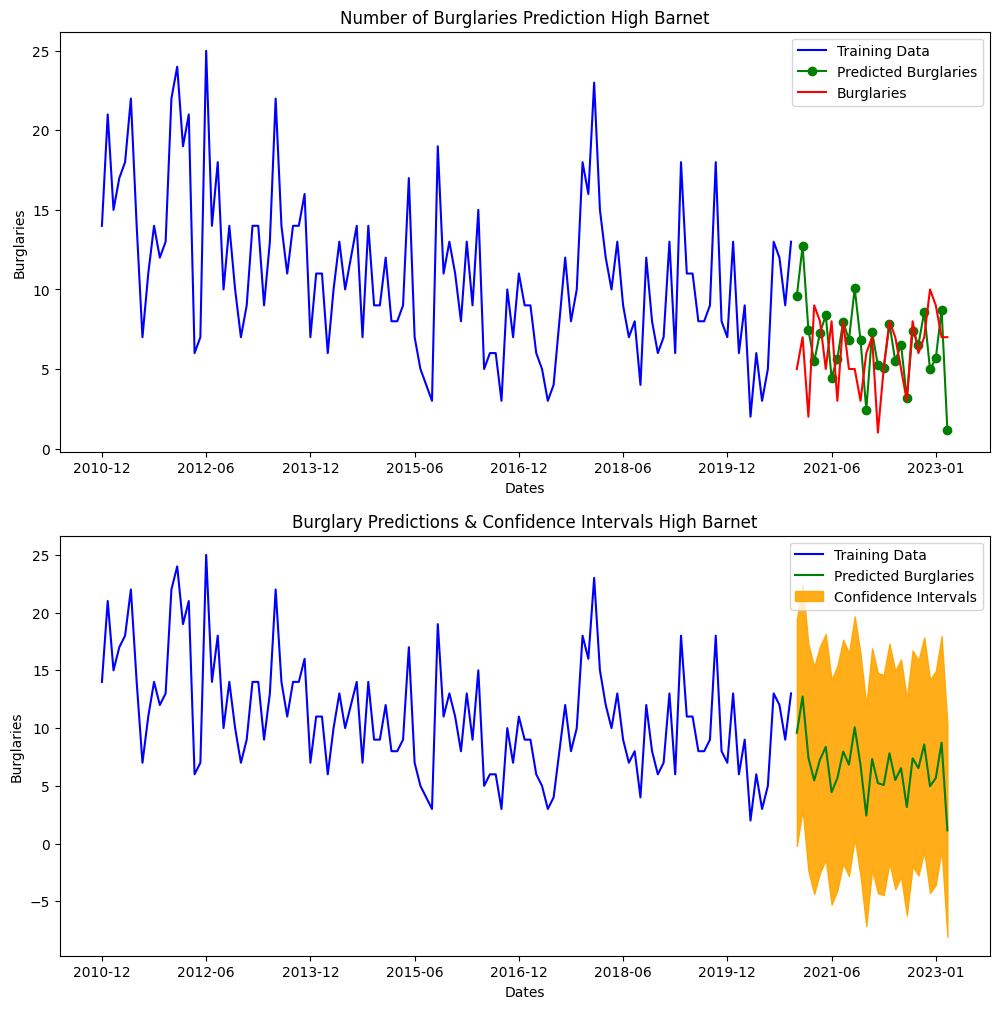

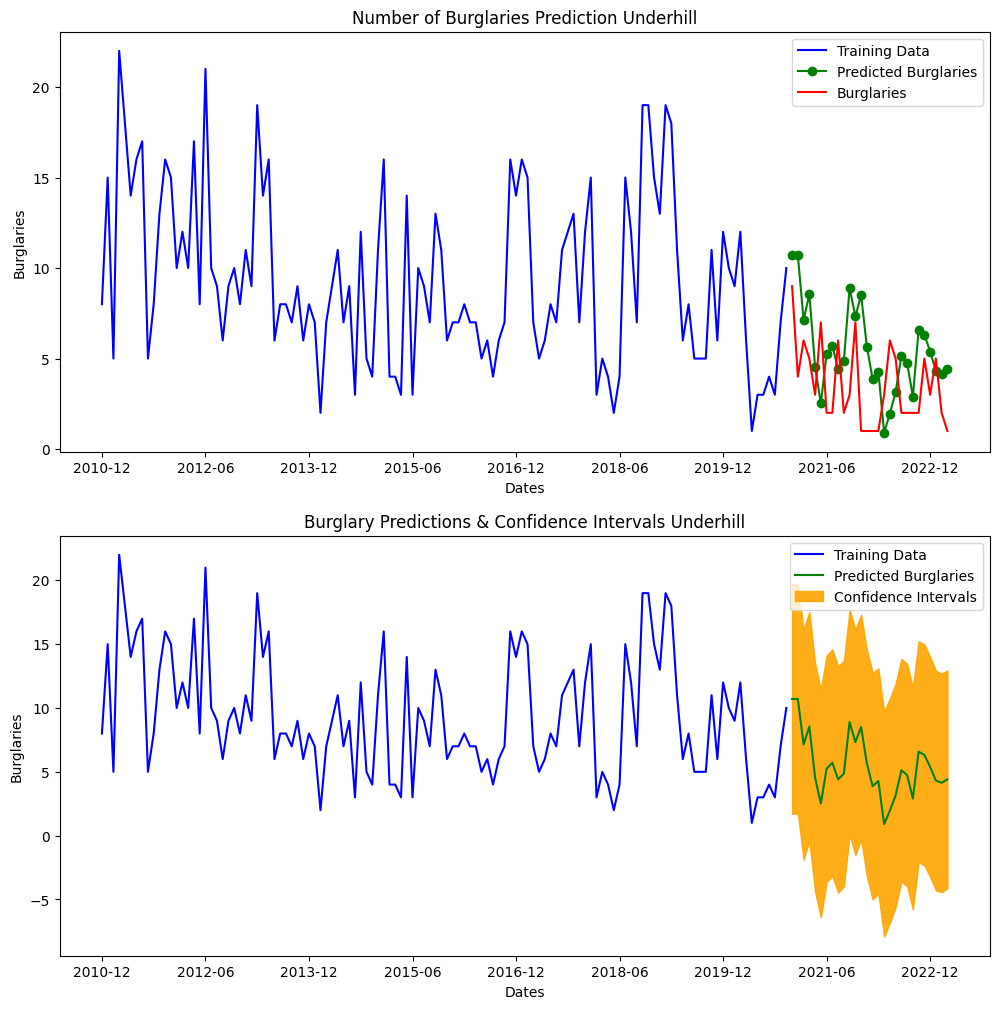

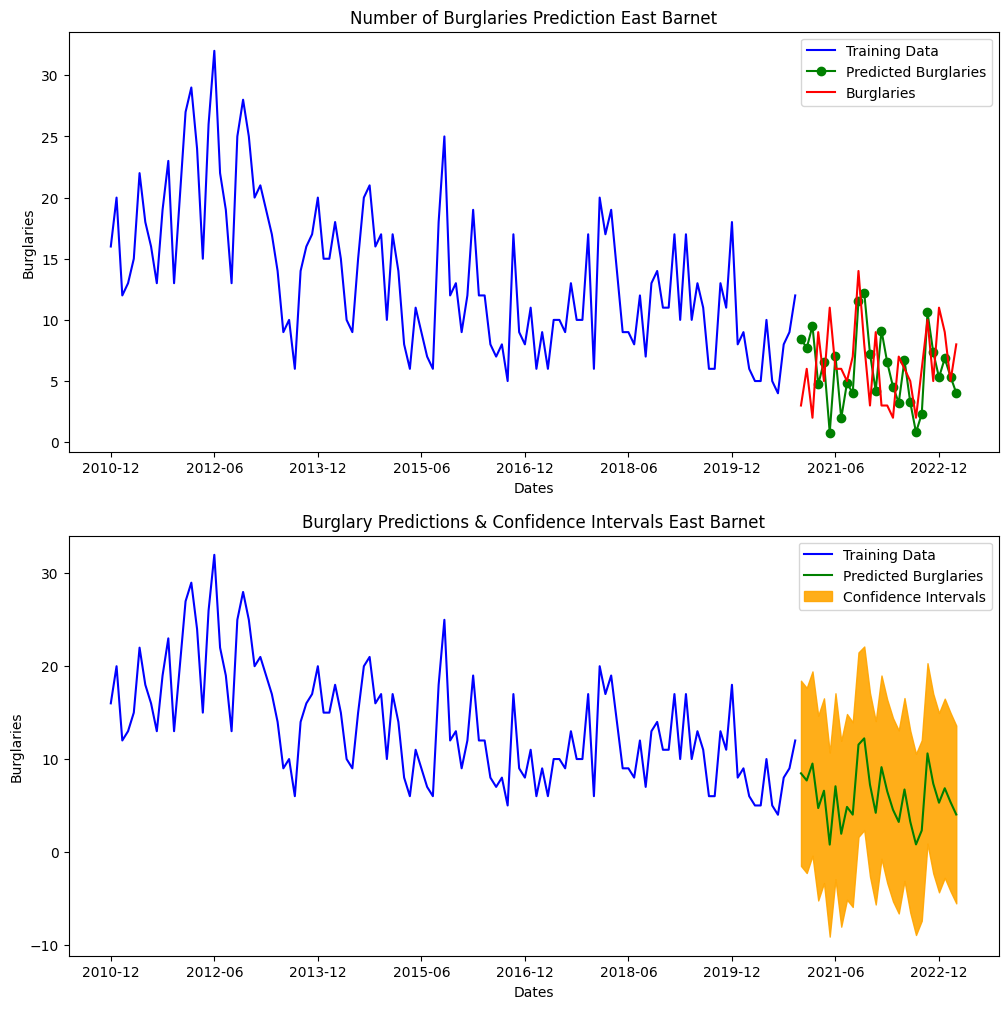

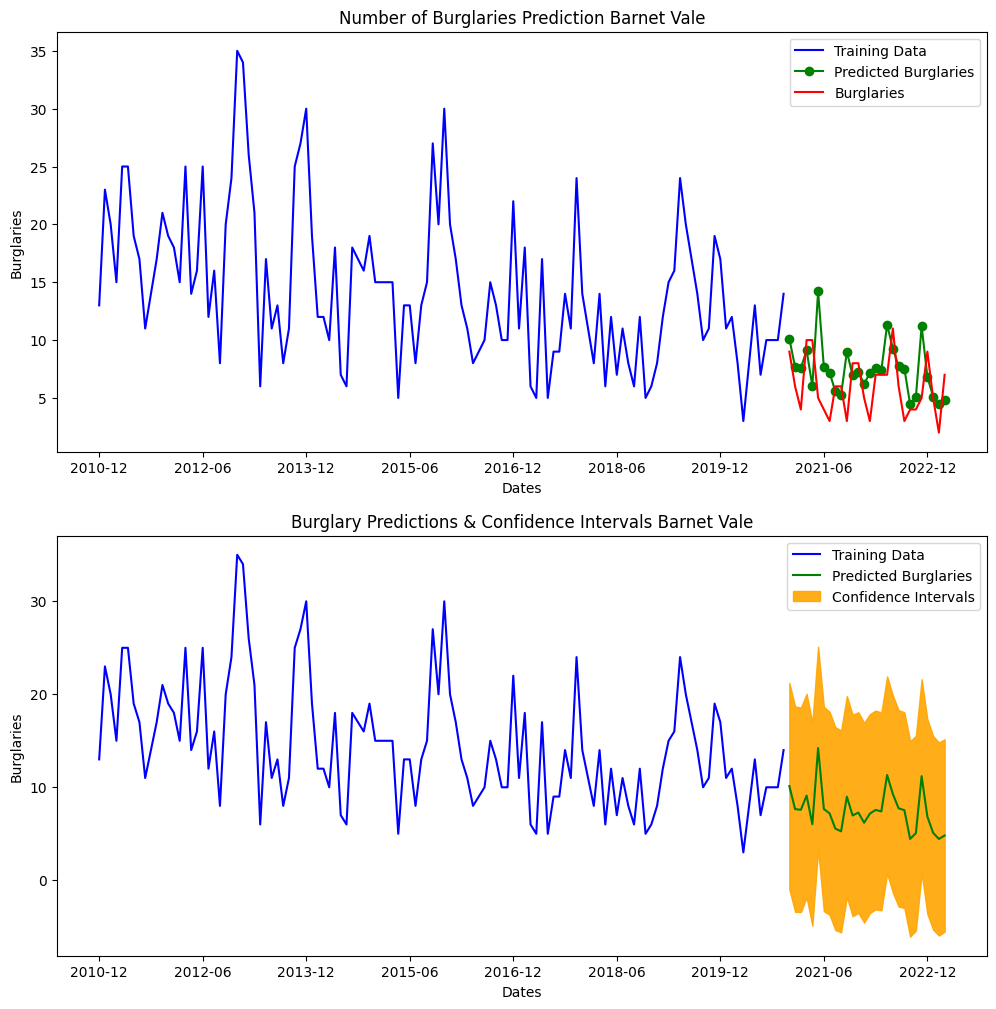

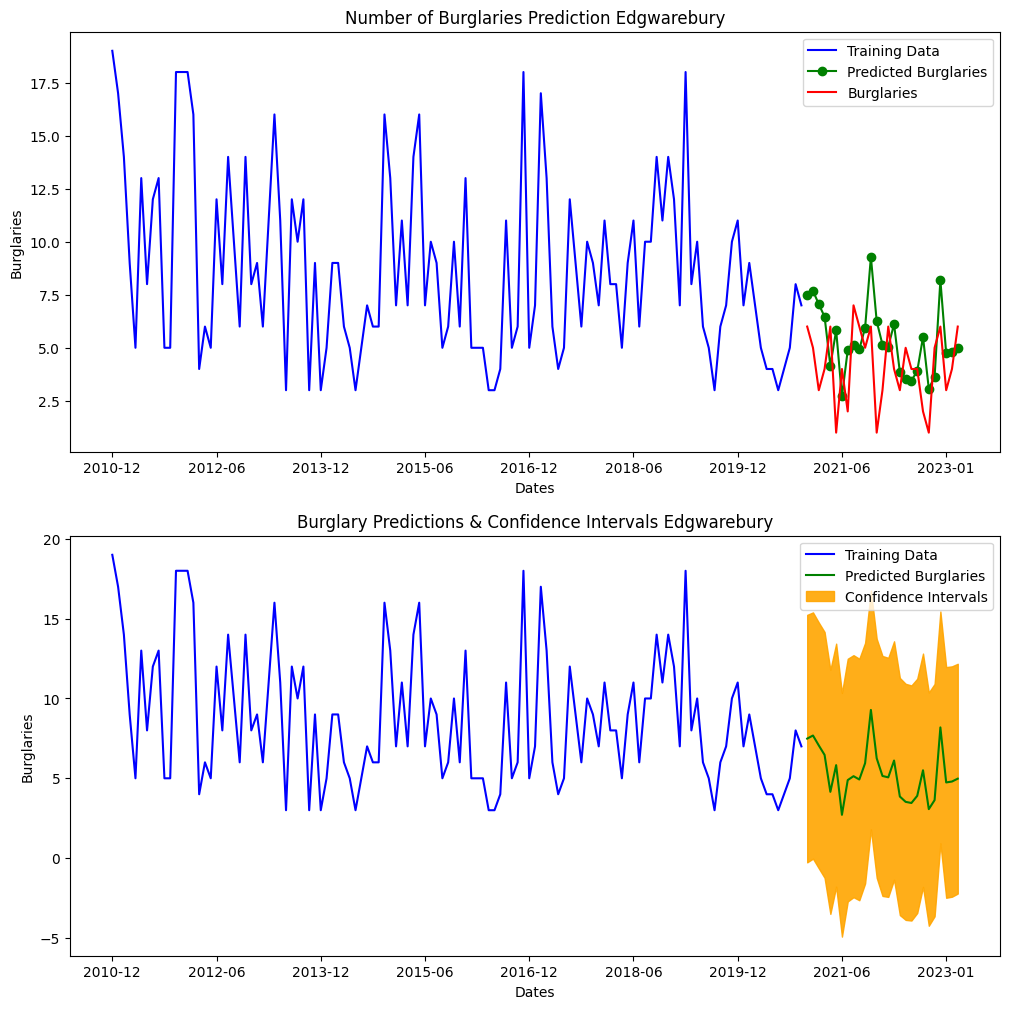

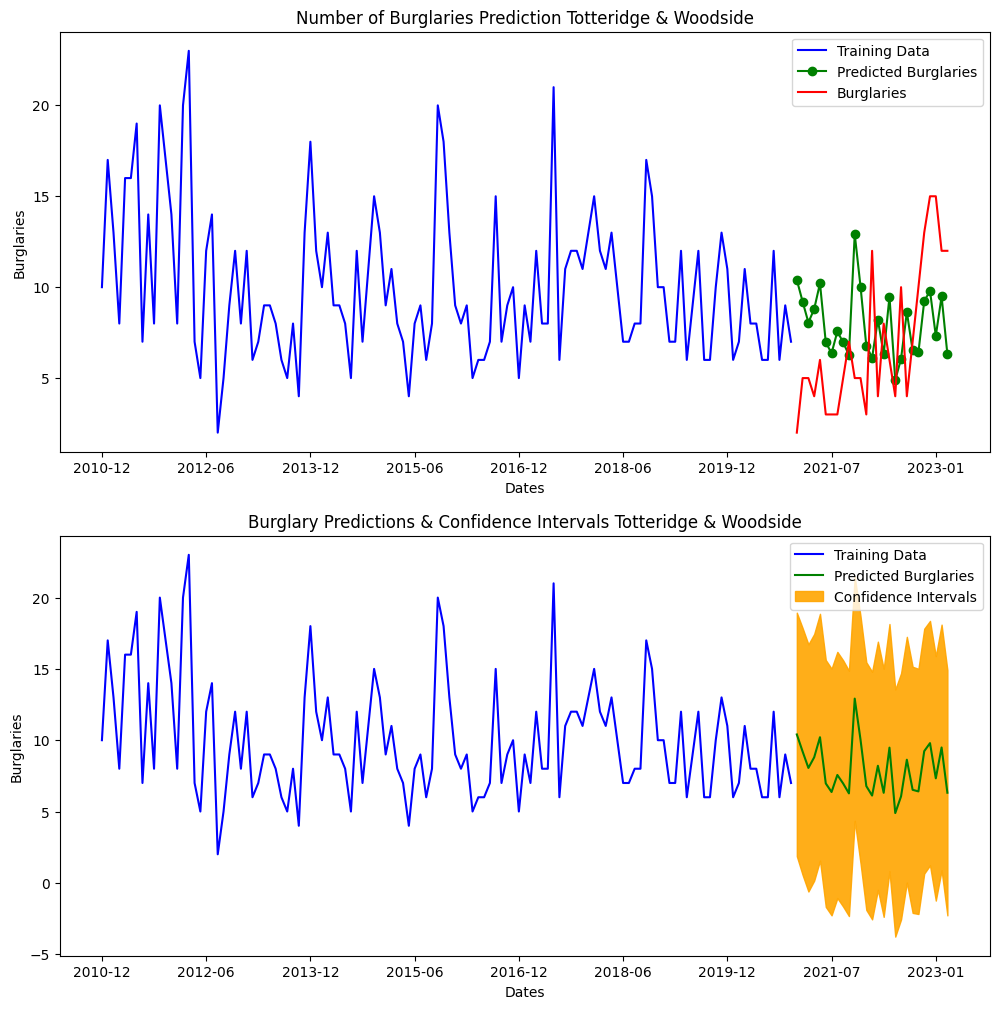

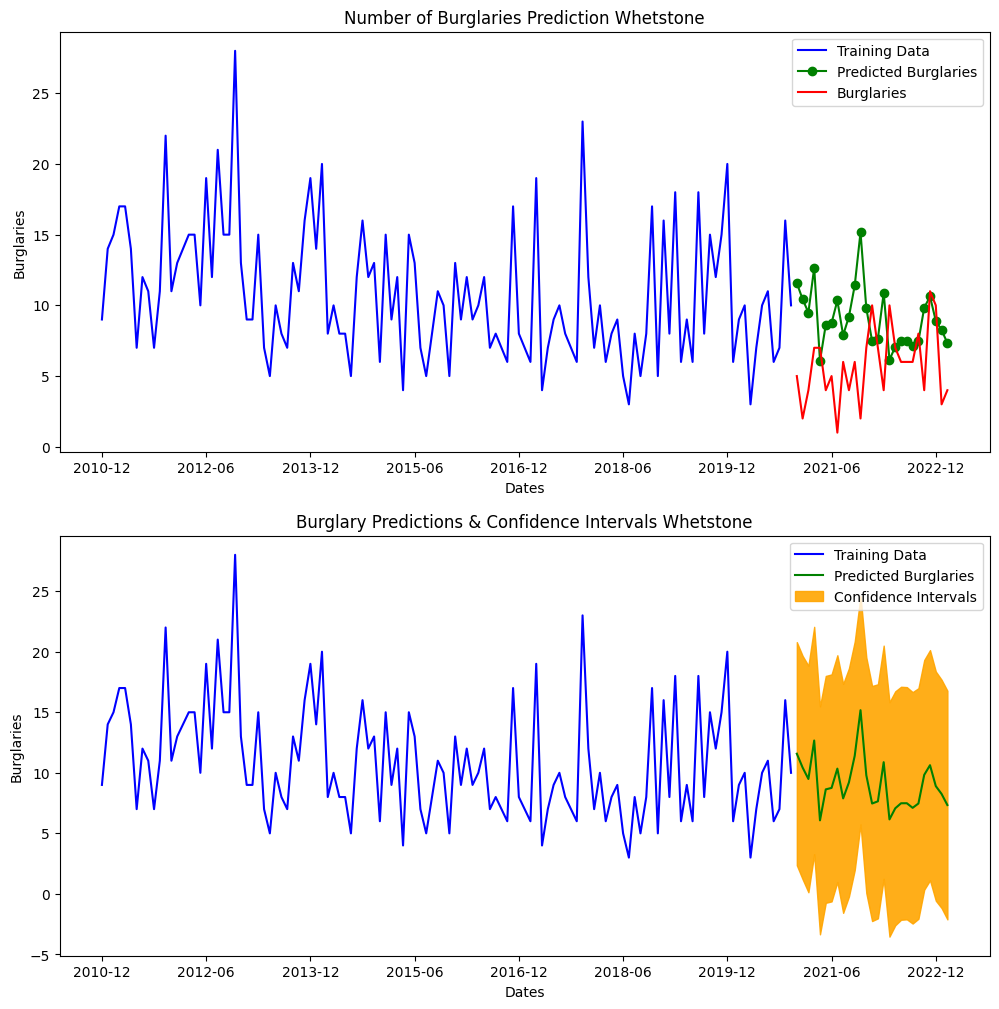

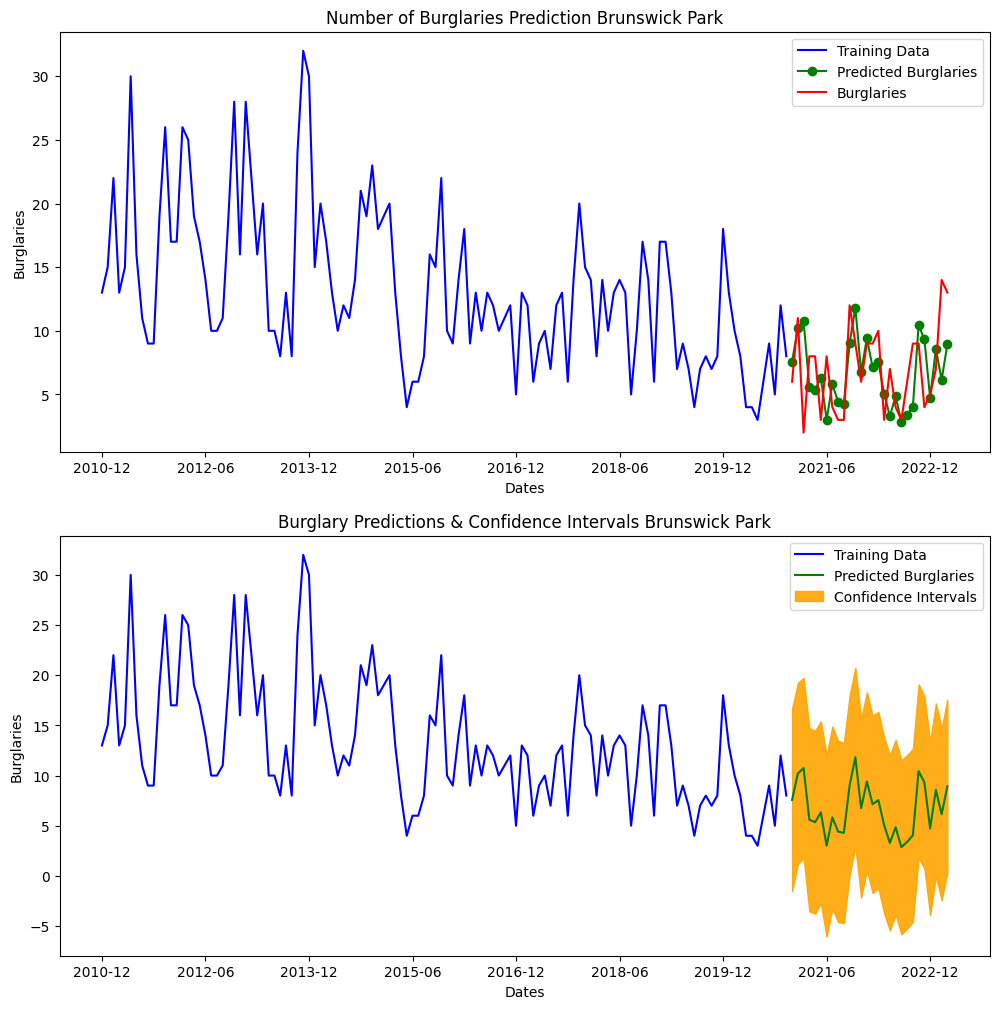

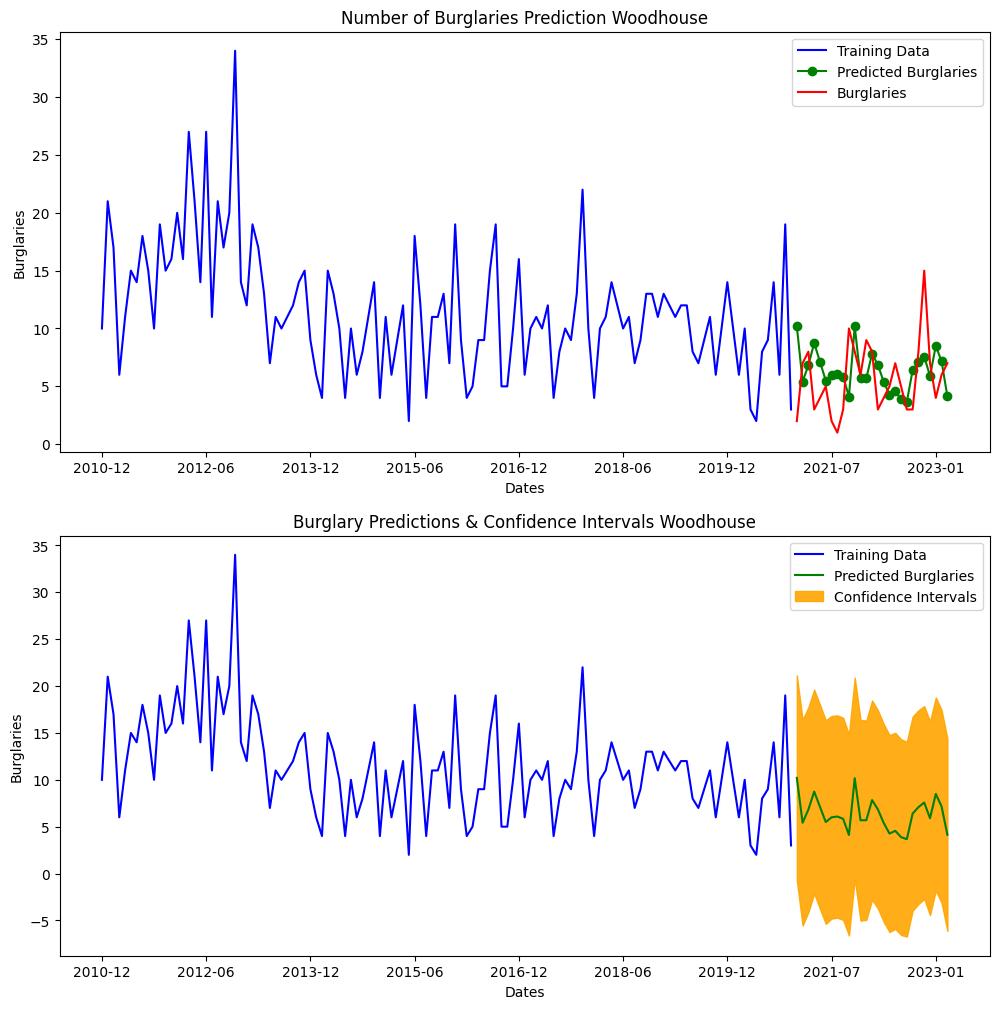

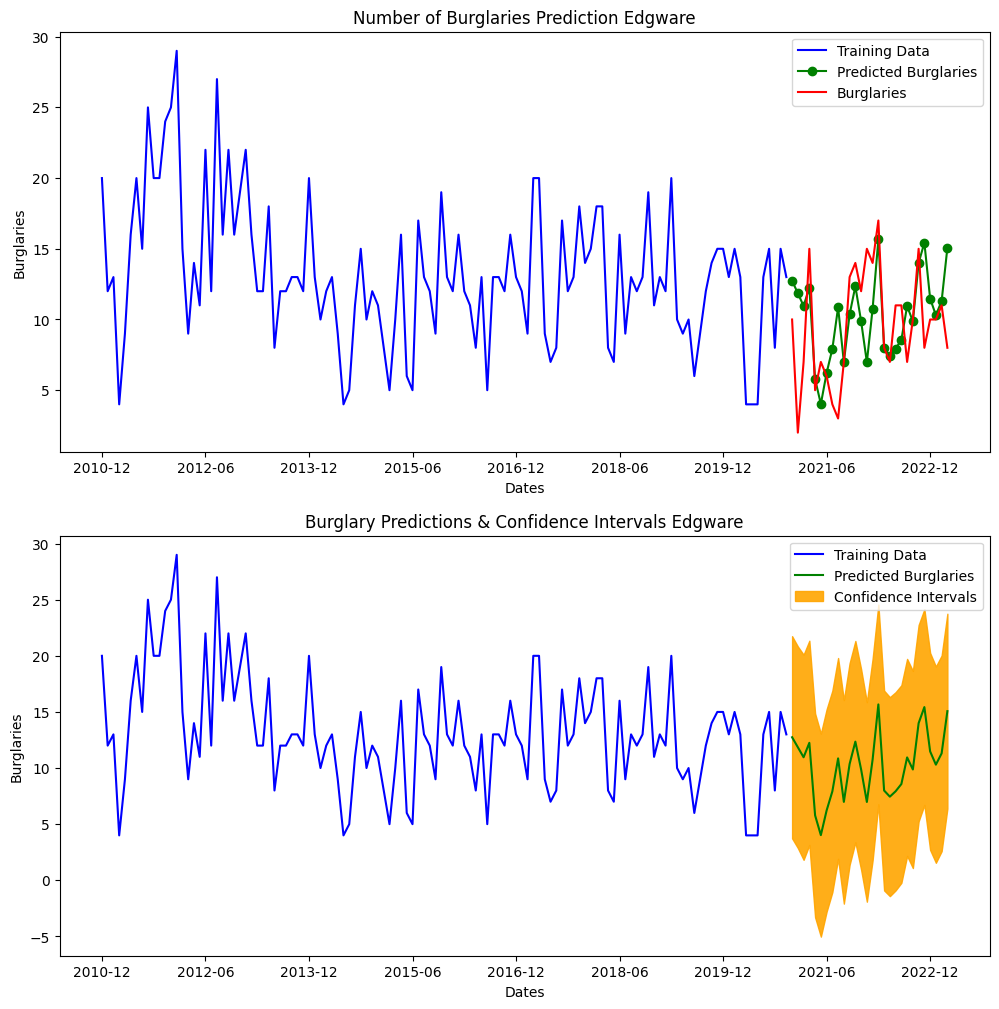

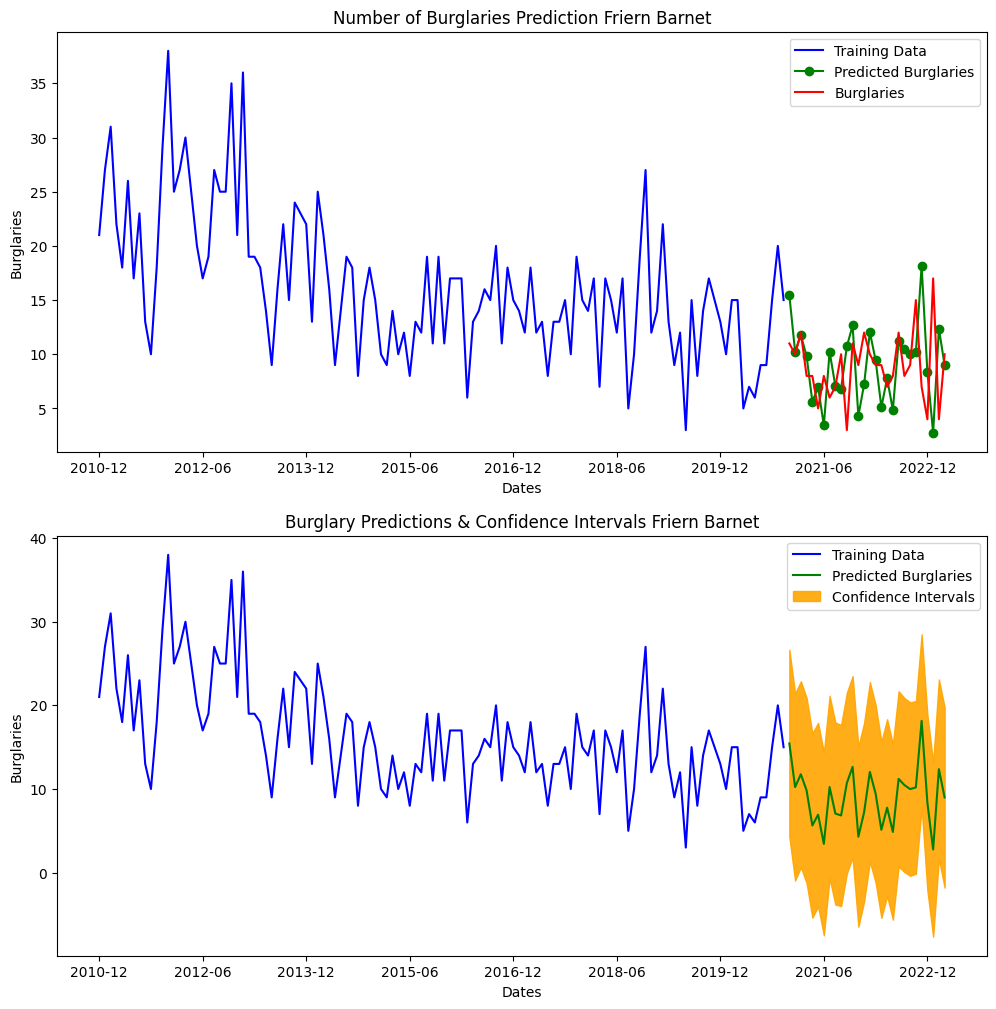

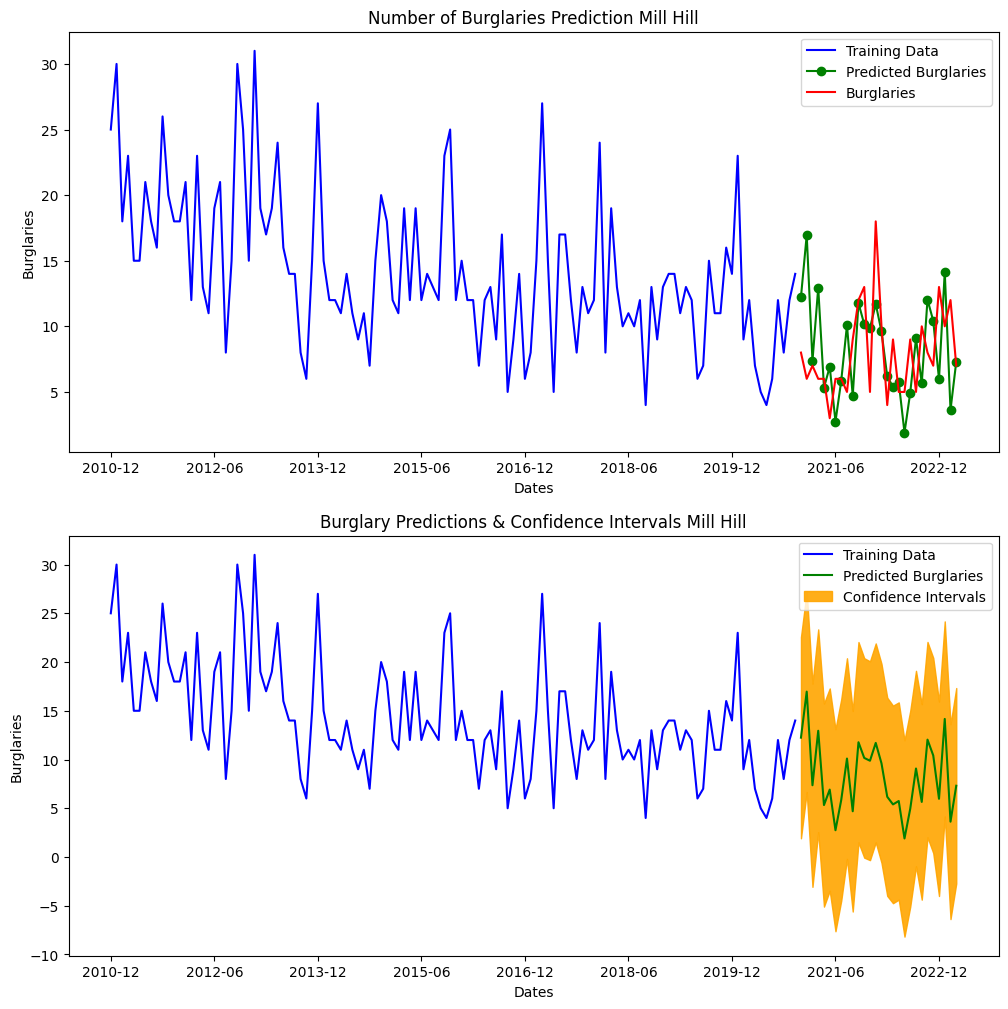

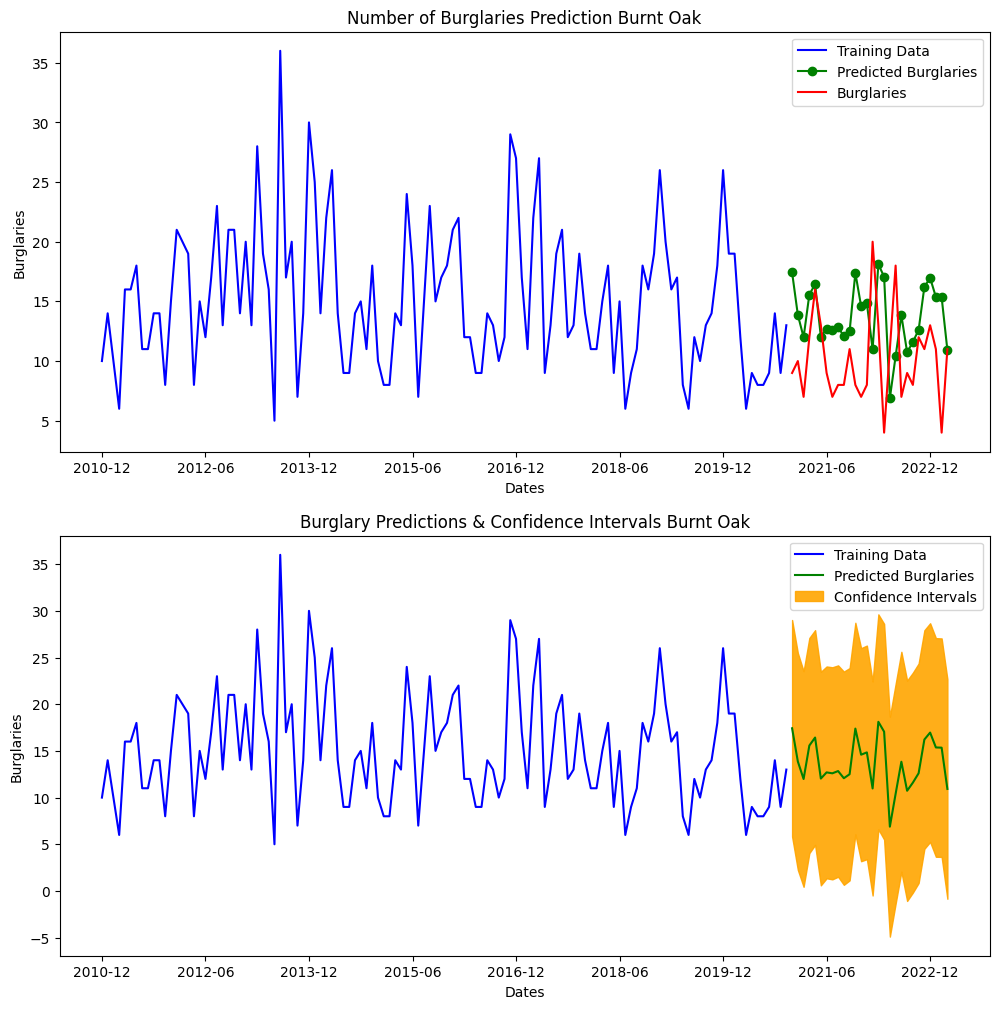

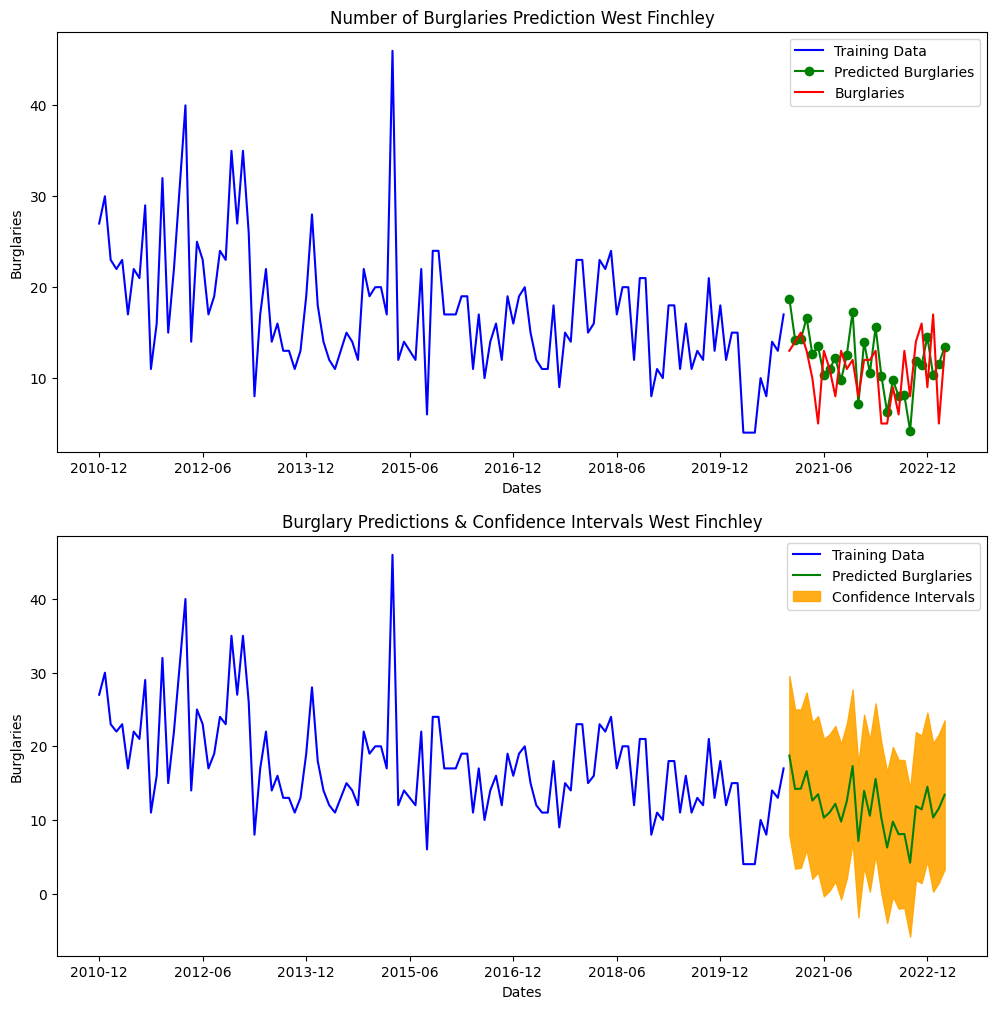

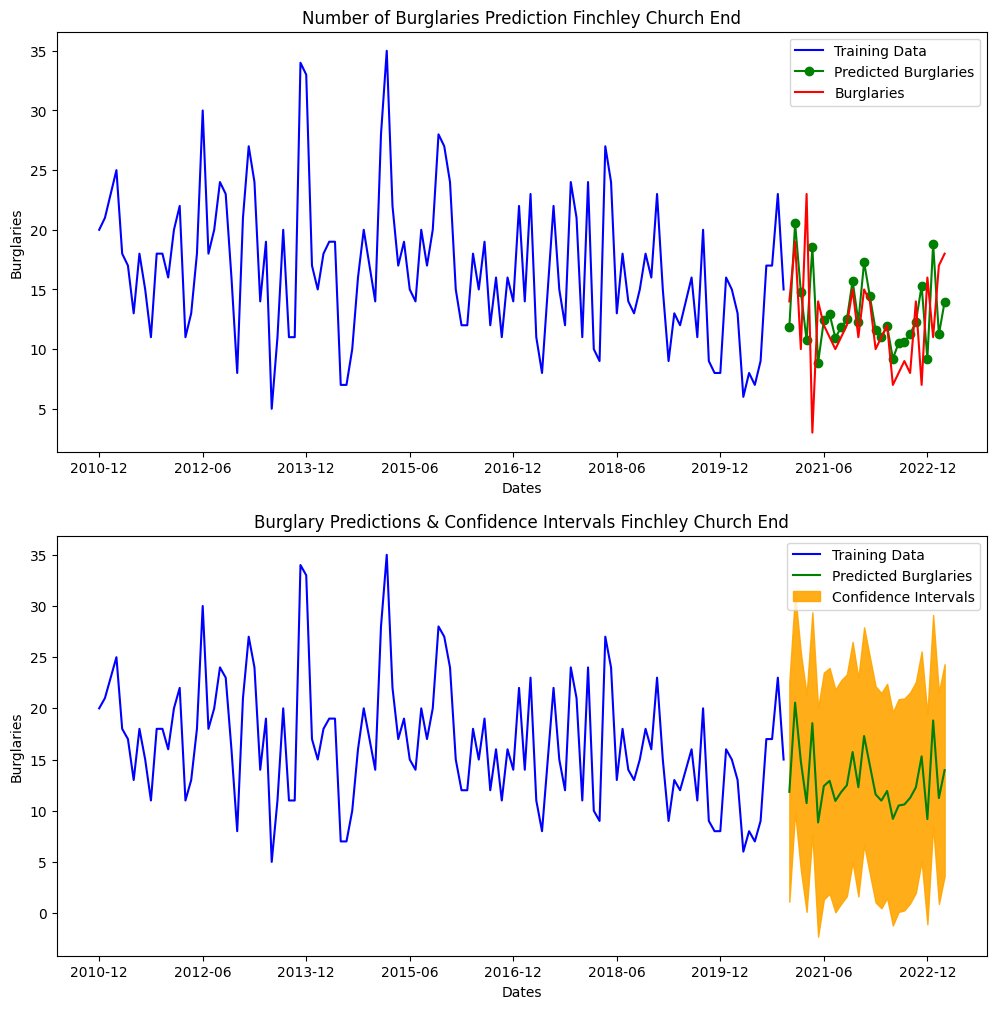

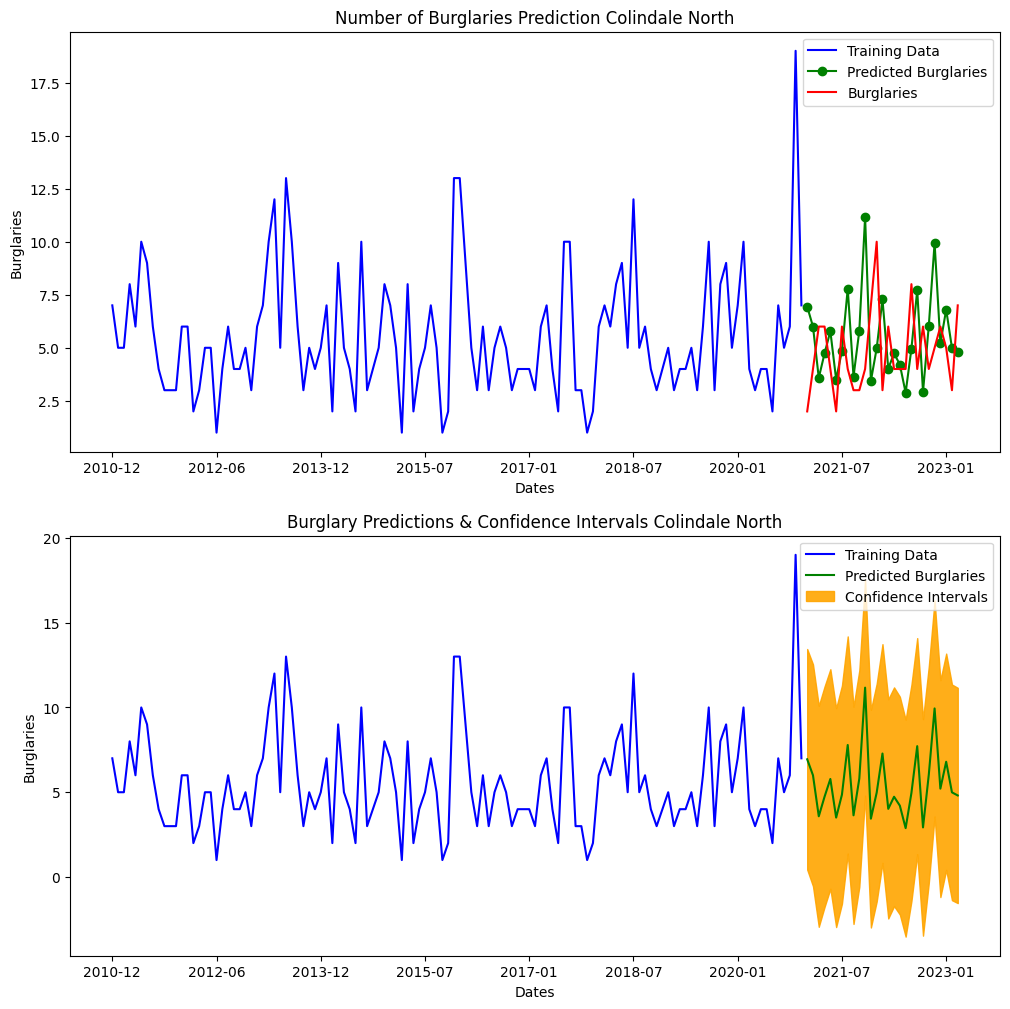

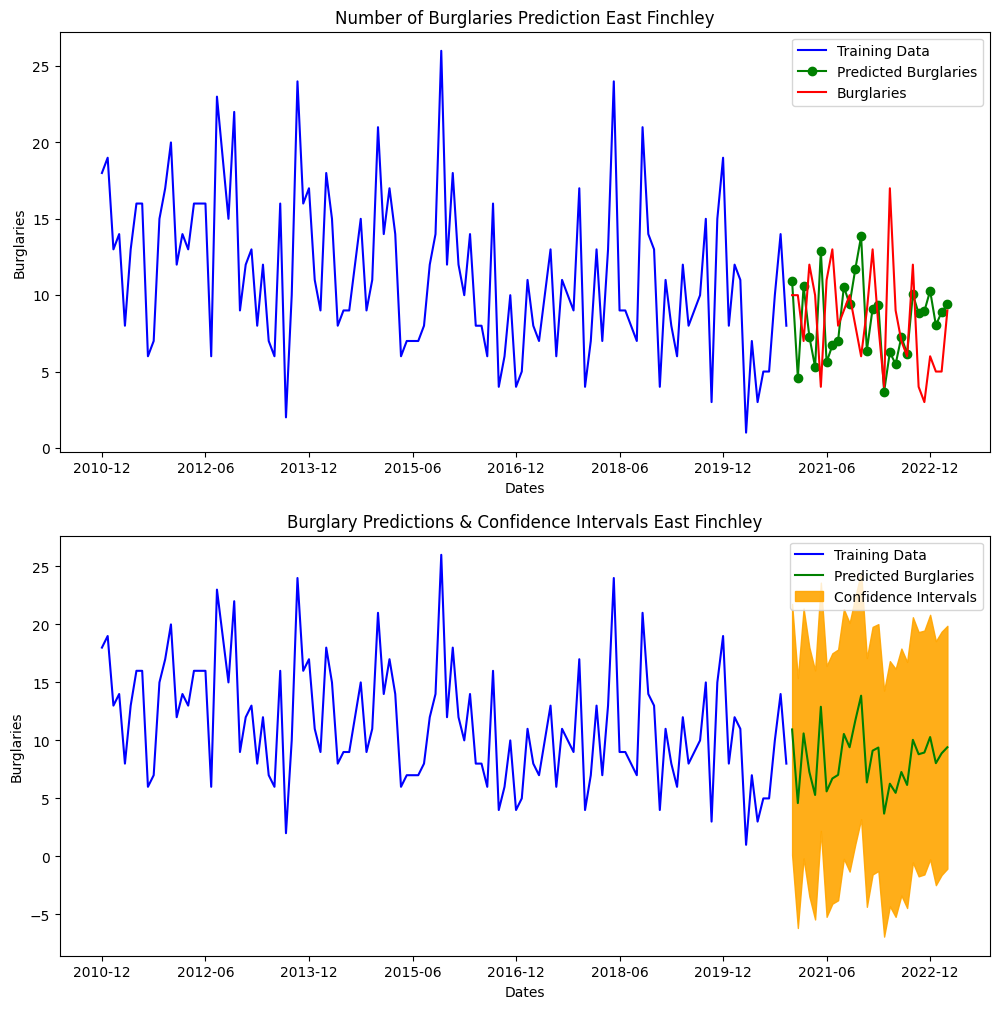

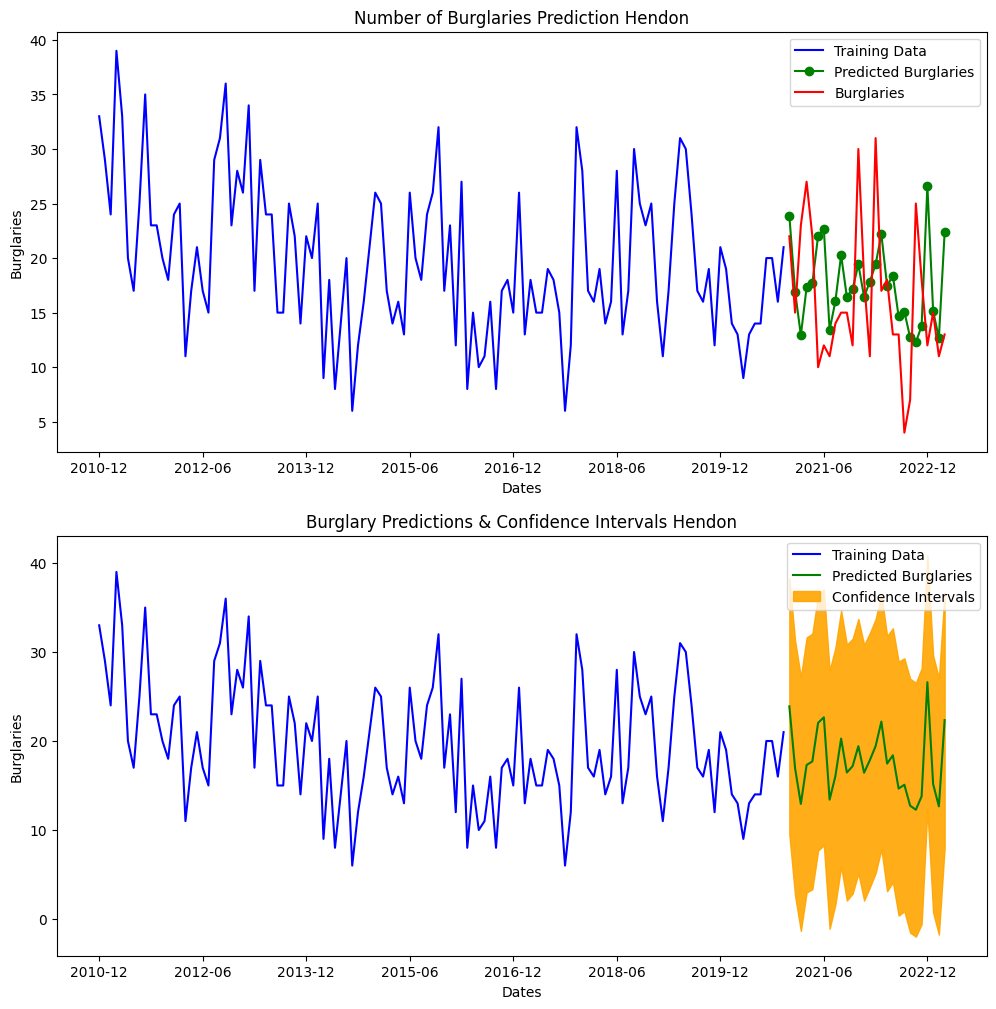

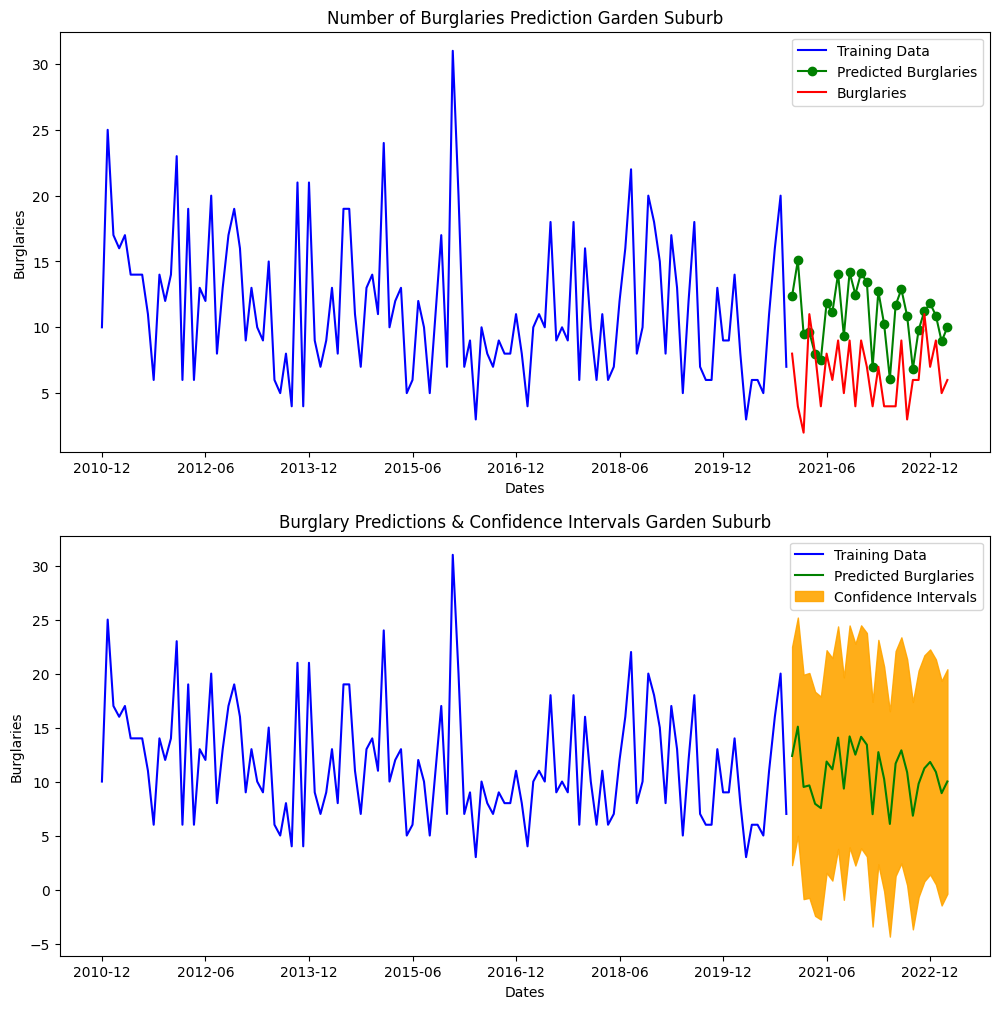

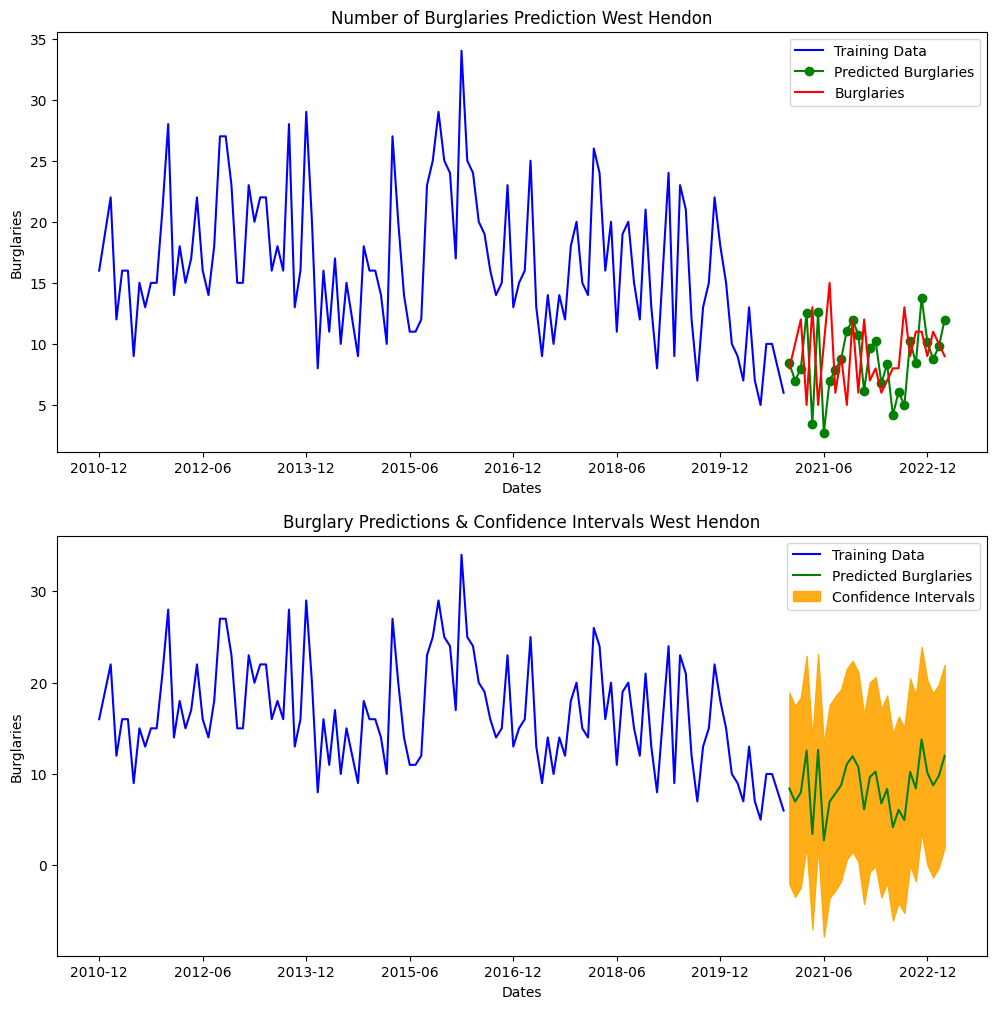

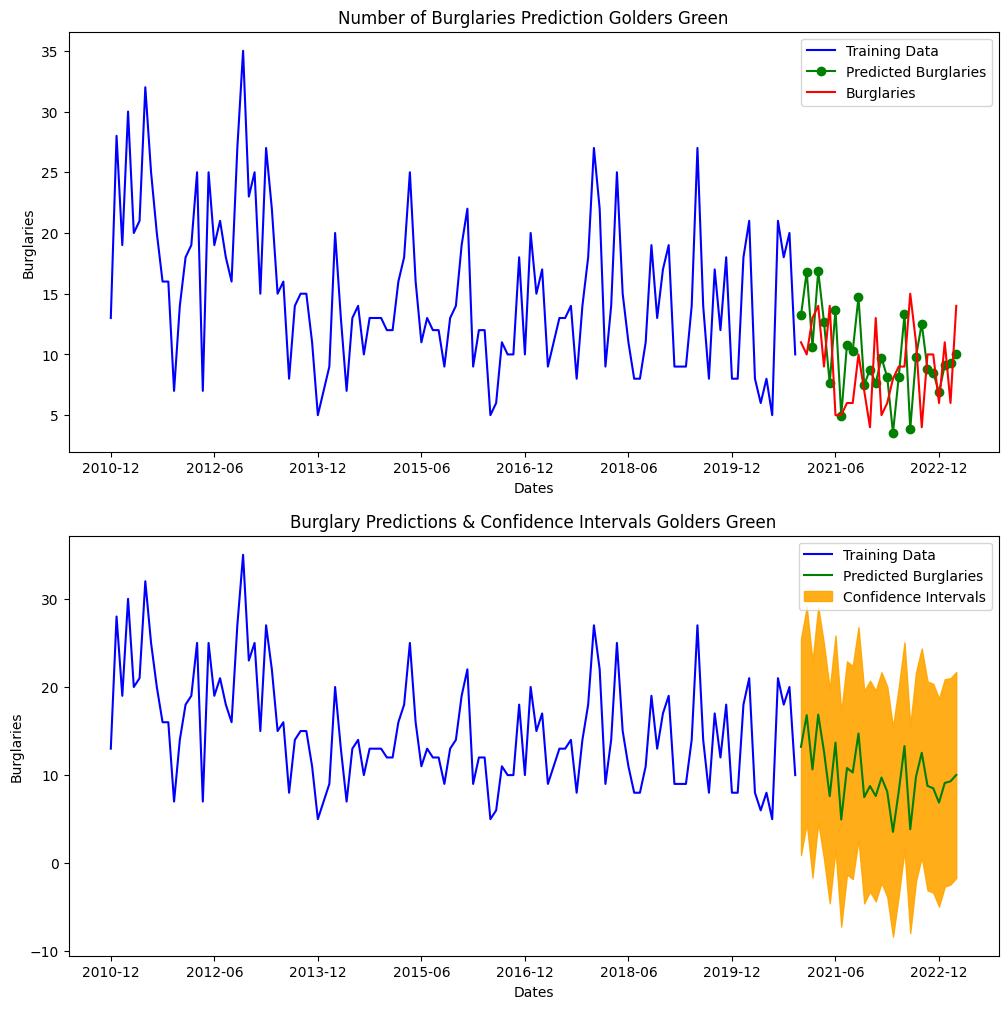

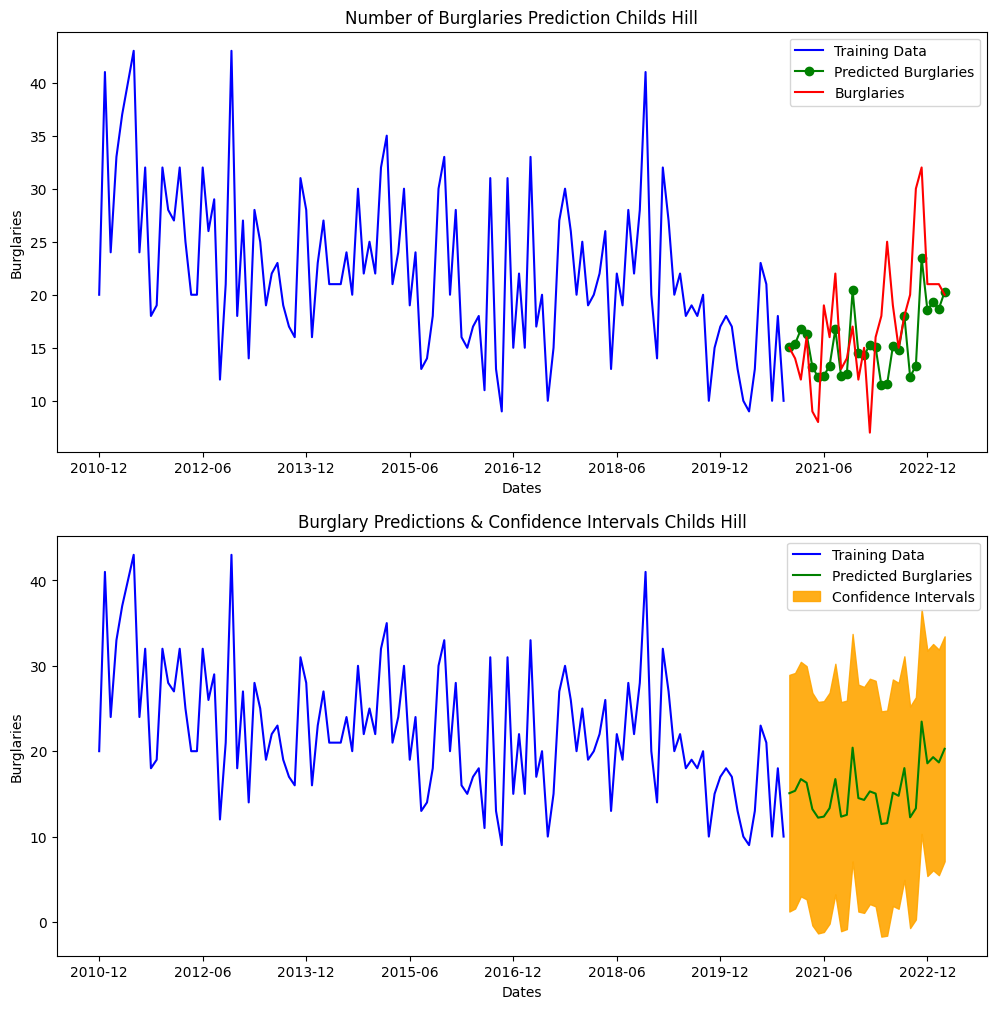

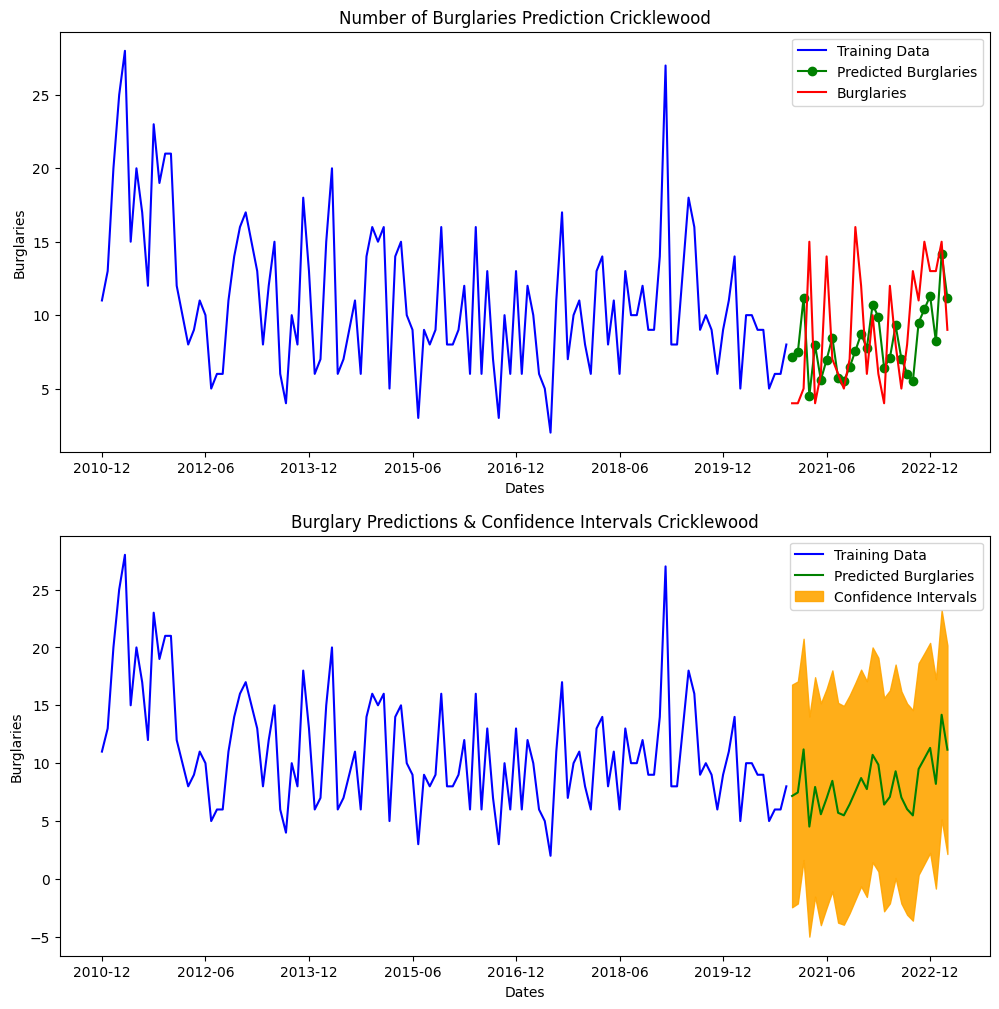

In [21]:
wards_list = ['High Barnet', 'Underhill', 'East Barnet', 'Barnet Vale',
       'Edgwarebury', 'Totteridge & Woodside', 'Whetstone',
       'Brunswick Park', 'Woodhouse', 'Edgware', 'Friern Barnet',
       'Mill Hill', 'Burnt Oak', 'West Finchley', 'Finchley Church End',
       'Colindale North', 'East Finchley', 'Hendon', 'Garden Suburb',
       'West Hendon', 'Golders Green', 'Childs Hill', 'Cricklewood']
predictions_dict = {}
for i in range(len(df_wards)):
    predictions_dict[wards_list[i]] = predictions_func(df_wards[i], 120, wards_list[i])


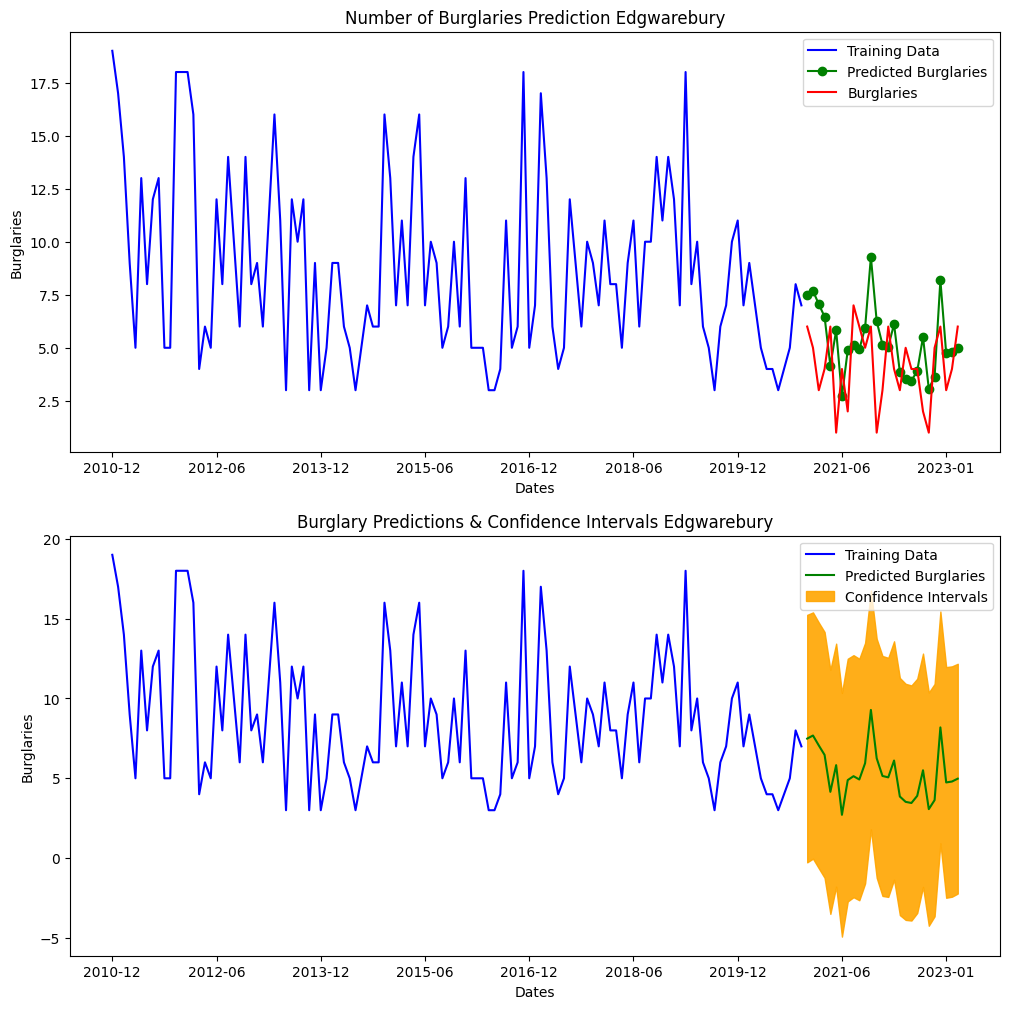

In [28]:
predictions_dict['Edgwarebury'][2]